In [26]:
import xscen as xs
from xscen.config import CONFIG, load_config

import xclim as xc
from xclim.core import dataflags

import xarray as xr
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import gridspec
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import seaborn as sns
import string
from dask.distributed import Client
import dask
import copy

import figanos.matplotlib as sp
sp.utils.set_mpl_style('ouranos')



load_config('../configuration/paths_ESPO-G_j.yml', '../configuration/config_ESPO-G_RDRS.yml', verbose=(__name__ == '__main__'), reset=True)
pcat = xs.ProjectCatalog(CONFIG['paths']['project_catalog'])
tdd = CONFIG['tdd']

INFO:xscen.config:Updated the config with ../configuration/paths_ESPO-G_j.yml.
INFO:xscen.config:Updated the config with ../configuration/config_ESPO-G_RDRS.yml.


# Health checks

In [2]:
import dask
dask.config.set({'logging.distributed': 'error'})
hausfather =['MIROC6','CMCC-ESM2', 'FGOALS-g3', 'ACCESS-CM2', 'ACCESS-ESM1-5', 'MPI-ESM1-2-HR', 'INM-CM5-0',
 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorESM2-LM', 'KACE-1-0-G', 'CNRM-ESM2-1', 'GFDL-ESM4', 'BCC-CSM2-MR']
#,silence_logs= True
with Client(n_workers=4, threads_per_worker=5, memory_limit="6GB", local_directory= '/exec/jlavoie/tmp_ic6/',
            dashboard_address=6786):
    dict_final = pcat.search(processing_level='final', domain='NAM-rdrs',experiment=['ssp370', 'ssp245'],
                            source=hausfather).to_dataset_dict(**tdd)
    
    # to make sure that everything has the same coords
    model_ds = dict_final[list(dict_final.keys())[0]]
    for i,ds in dict_final.items():
        print('')
        print(i)
        for c in model_ds.coords:
            if not model_ds[c].equals(ds[c]):
                print(f"{c} is different.")
                
        xc.core.datachecks.check_daily(ds)
        
        if dataflags.temperature_extremely_high(ds['tasmax']).any().values:
            print('temperature_extremely_high')
        if dataflags.temperature_extremely_low(ds['tasmin'], thresh='100 K').any().values:
            print('temperature_extremely_low 100K')
        if dataflags.negative_accumulation_values(ds['pr']).any().values:
            print('negative_accumulation_values')
        if dataflags.tasmax_below_tasmin(tasmax=ds['tasmax'], tasmin=ds['tasmin']).any().values:
            print('tasmax_below_tasmin')
        if dataflags.temperature_extremely_low(ds['tasmin'], thresh='-70 degC').any().values:
            print('temperature_extremely_low -70degC')
        if dataflags.very_large_precipitation_events(ds['pr'], thresh='1650 mm/d').any().values:
            print('very_large_precipitation_events')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


CMIP6_ScenarioMIP_DKRZ_MPI-ESM1-2-HR_ssp370_r1i1p1f1_global.NAM-rdrs.final.D
temperature_extremely_low -70degC
very_large_precipitation_events
CMIP6_ScenarioMIP_NCC_NorESM2-LM_ssp245_r1i1p1f1_global.NAM-rdrs.final.D
temperature_extremely_low -70degC
CMIP6_ScenarioMIP_CAS_FGOALS-g3_ssp370_r1i1p1f1_global.NAM-rdrs.final.D
temperature_extremely_low -70degC
CMIP6_ScenarioMIP_MIROC_MIROC6_ssp370_r1i1p1f1_global.NAM-rdrs.final.D
temperature_extremely_low -70degC
CMIP6_ScenarioMIP_NIMS-KMA_KACE-1-0-G_ssp370_r1i1p1f1_global.NAM-rdrs.final.D
time is different.
temperature_extremely_low -70degC
very_large_precipitation_events
CMIP6_ScenarioMIP_NOAA-GFDL_GFDL-ESM4_ssp370_r1i1p1f1_global.NAM-rdrs.final.D
temperature_extremely_low -70degC
CMIP6_ScenarioMIP_INM_INM-CM5-0_ssp245_r1i1p1f1_global.NAM-rdrs.final.D
temperature_extremely_low -70degC
CMIP6_ScenarioMIP_MRI_MRI-ESM2-0_ssp245_r1i1p1f1_global.NAM-rdrs.final.D
temperature_extremely_low -70degC
CMIP6_ScenarioMIP_INM_INM-CM5-0_ssp370_r1i1p1f1_glo

# maps

In [164]:
#load all properties from ref, sim, scen

hausfather =['MIROC6','CMCC-ESM2', 'FGOALS-g3', 'ACCESS-CM2', 'ACCESS-ESM1-5', 'MPI-ESM1-2-HR', 'INM-CM5-0',
 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorESM2-LM', 'KACE-1-0-G', 'CNRM-ESM2-1', 'GFDL-ESM4', 'BCC-CSM2-MR']

def _rmse(sim, ref):
    return np.sqrt(np.nanmean((sim - ref) ** 2, axis=-1))

def maps(option_id, option_region, option_var):
    "Load properties and measures and plot them."
    
    # get data from catalogue
    prop_ref = pcat.search( processing_level=['diag-ref-prop*', 'diag_ref_prop'], domain=option_region, variable=option_var).to_dask()[option_var]
    prop_sim = pcat.search(id= option_id, processing_level='diag-sim-prop*', domain=option_region, variable=option_var).to_dask()[option_var]
    prop_scen = pcat.search(id= option_id, processing_level='diag-scen-prop*', domain=option_region, variable=option_var).to_dask()[option_var]
    meas_sim_prop = pcat.search(id=option_id, processing_level='diag-sim-meas*', domain=option_region, variable=option_var).to_dask()[option_var]
    meas_scen_prop = pcat.search(id=option_id, processing_level='diag-scen-meas*', domain=option_region, variable=option_var).to_dask()[option_var]
    
    
    #transpose
    if 'corr_' in option_var or 'max_warm_spell'==option_var:
        prop_ref=prop_ref.transpose()
        prop_sim=prop_sim.transpose()
        prop_scen=prop_scen.transpose()
        meas_sim_prop=meas_sim_prop.transpose()
        meas_scen_prop=meas_scen_prop.transpose()
        # force the right cbar
        prop_ref.name= prop_ref.name+ " pr"
        prop_sim.name=prop_sim.name+ " pr"
        prop_scen.name=prop_scen.name+ " pr"
        meas_sim_prop.name=meas_sim_prop.name+ " pr"
        meas_scen_prop.name=meas_scen_prop.name+ " pr"
    
    prop_long_name=prop_sim.attrs['long_name'] 
    meas_long_name=meas_sim_prop.attrs['long_name'] 
    # change units
    if prop_ref.attrs['units']=='kg m-2 s-1':
        prop_ref = xc.core.units.convert_units_to(prop_ref, 'mm d-1', context='hydro')
        prop_sim = xc.core.units.convert_units_to(prop_sim, 'mm d-1', context='hydro')
        prop_scen = xc.core.units.convert_units_to(prop_scen, 'mm d-1', context='hydro')
        meas_sim_prop = xc.core.units.convert_units_to(meas_sim_prop, 'mm d-1', context='hydro')
        meas_scen_prop = xc.core.units.convert_units_to(meas_scen_prop, 'mm d-1', context='hydro')
        
    if prop_ref.attrs['units']=='K':
        prop_ref = xc.core.units.convert_units_to(prop_ref, 'degC')
        prop_sim = xc.core.units.convert_units_to(prop_sim, 'degC')
        prop_scen = xc.core.units.convert_units_to(prop_scen, 'degC')
        
    #set colormap
    maxi_prop = max(prop_ref.max().values, prop_scen.max().values, prop_sim.max().values)
    mini_prop = min(prop_ref.min().values, prop_scen.min().values, prop_sim.min().values)
    maxi_meas = float(max(abs(meas_scen_prop).max().values, abs(meas_sim_prop).max().values))

    #plot
    fig = plt.figure(figsize=(15, 8))
    map_proj = ccrs.RotatedPole(pole_longitude=87.59703063964844,
                          pole_latitude=31.758316040039062,
                         )
    gs = gridspec.GridSpec(4, 3)
    ax0= fig.add_subplot(gs[1:3,0],projection=map_proj)
    ax1= fig.add_subplot(gs[:2,1],projection=map_proj)
    ax2= fig.add_subplot(gs[:2,2],projection=map_proj)
    ax3= fig.add_subplot(gs[2:,1],projection=map_proj)
    ax4= fig.add_subplot(gs[2:,2],projection=map_proj)

    plot_kw_prop=dict(add_colorbar=False, vmin=mini_prop,vmax=maxi_prop)
    plot_kw_meas=dict(add_colorbar=False, vmin=-maxi_meas,vmax=maxi_meas)
    features={ 'lakes':{'scale':'110m', 'edgecolor':'black', 'facecolor':'none'},'coastline':{'scale':'50m'}}
    #plot
    # deep copy until bug is fix TODO
    sp.gridmap(prop_ref, ax=ax0, plot_kw=plot_kw_prop, features=copy.deepcopy(features))
    sp.gridmap(prop_sim, ax=ax1, plot_kw=plot_kw_prop, features=copy.deepcopy(features))
    sp.gridmap(prop_scen, ax=ax3, plot_kw=plot_kw_prop, features=copy.deepcopy(features))
    sp.gridmap(meas_sim_prop, ax=ax2, plot_kw=plot_kw_meas,divergent=0, features=copy.deepcopy(features))
    sp.gridmap(meas_scen_prop, ax=ax4, plot_kw=plot_kw_meas,divergent=0, features=copy.deepcopy(features))

    #prop colorbar
    fig.subplots_adjust(bottom=0.1)
    cbar_ax = fig.add_axes([0.15, 0.01, 0.45, 0.03])
    cb1=fig.colorbar(ax0.get_children()[0], cax=cbar_ax,orientation='horizontal')
    cb1.set_label(label=f"{prop_long_name} ({prop_sim.attrs['units']})",size=15)
    cb1.ax.tick_params(axis='x', direction='out')
    cb1.outline.set_visible(False)
    
    #meas colorbar
    fig.subplots_adjust(bottom=0.1)
    cbar_ax = fig.add_axes([0.68, 0.01, 0.25, 0.03])
    cb2=fig.colorbar(ax2.get_children()[0], cax=cbar_ax,orientation='horizontal')
    cb2.set_label(label=f"{meas_long_name} ({meas_sim_prop.attrs['units']})",size=15)
    
    cb2.ax.tick_params(axis='x', direction='out')
    cb2.outline.set_visible(False)
    
    
    #rmse
    rmse_sim = xr.apply_ufunc(
        _rmse,
        prop_sim.stack(loc=['rlat','rlon']).chunk(dict(loc=-1)),
        prop_ref.stack(loc=['rlat','rlon']).chunk(dict(loc=-1)),
        input_core_dims=[["loc"], ["loc"]],
        dask="parallelized",
    ).values
    
    
    rmse_scen = xr.apply_ufunc(
        _rmse,
        prop_scen.stack(loc=['rlat','rlon']).chunk(dict(loc=-1)),
        prop_ref.stack(loc=['rlat','rlon']).chunk(dict(loc=-1)),
        input_core_dims=[["loc"], ["loc"]],
        dask="parallelized",
    ).values
    
    fs=15
    ax0.set_title(r'a) reference', fontsize=fs)
    ax1.set_title(r'b) original', fontsize=fs)
    prop_sim.attrs['units']=prop_sim.attrs['units'].replace('mm d-1', 'mm/d')
    prop_scen.attrs['units']=prop_scen.attrs['units'].replace('mm d-1', 'mm/d')
    ax2.set_title(f"c) original \n RMSE={rmse_sim:.2f} {prop_sim.attrs['units']}",
                  fontsize=fs)
    ax3.set_title(r'd) bias-adjusted', fontsize=fs)
    ax4.set_title(f"e) bias-adjusted \n RMSE={rmse_scen:.2f} {prop_scen.attrs['units']}",
                  fontsize=fs)
    fig.tight_layout(pad=5.0)
    return fig,[ax0,ax1,ax2,ax3,ax4], [cb1,cb2]
    

/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "long_name" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "long_name" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "long_name" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-fig/lib

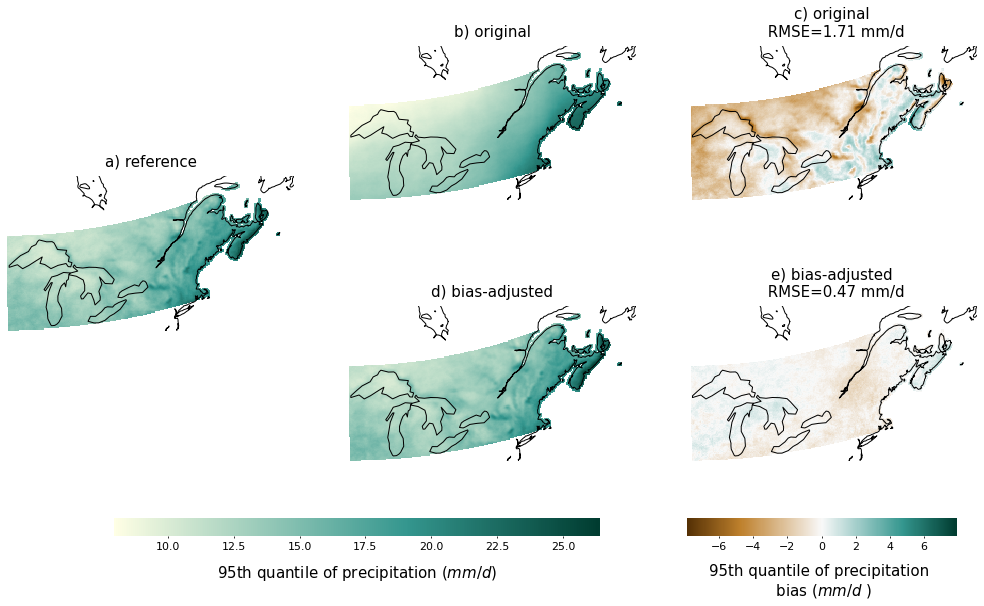

In [165]:
option_id ='CMIP6_ScenarioMIP_NIMS-KMA_KACE-1-0-G_ssp370_r1i1p1f1_global'
option_region = 'Magtogoek81-rdrs'
option_var = 'q95_pr'
fig, axs, cbs=maps(option_id=option_id, option_region=option_region, option_var=option_var)
cbs[1].set_label("95th quantile of precipitation \n bias "+r"($mm/d$ )", labelpad=12)
cbs[0].set_label("95th quantile of precipitation "+r"($mm/d$)", labelpad=12)
plt.savefig(f"{CONFIG['paths']['figures']}q95_pr.eps", format='eps',bbox_inches='tight')


/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/tmp/ipykernel_64329/3711260675.py:80: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/tmp/ipykernel_64329/3711260675.py:88: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/t

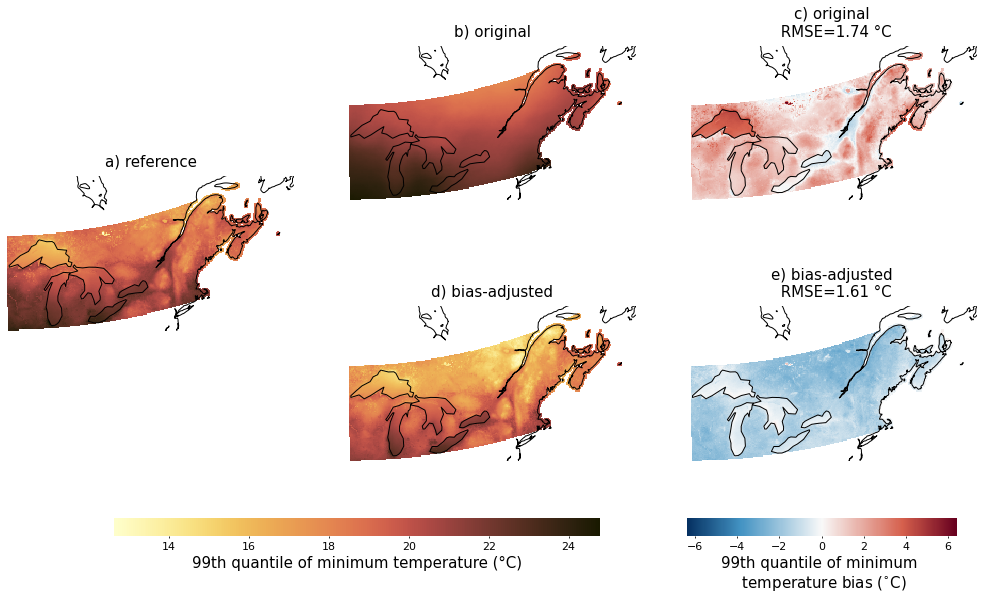

In [166]:
option_id ='CMIP6_ScenarioMIP_MIROC_MIROC6_ssp370_r1i1p1f1_global'
option_region = 'Magtogoek81-rdrs'
option_var = 'q99_tasmin'
fig, axs, cbs=maps(option_id=option_id, option_region=option_region, option_var=option_var)
cbs[1].set_label("99th quantile of minimum \n temperature bias "+r"($^{\circ}$C)")
plt.savefig(f"{CONFIG['paths']['figures']}q99_tasmin.eps", format='eps',bbox_inches='tight')

/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/tmp/ipykernel_64329/1001469890.py:80: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/tmp/ipykernel_64329/1001469890.py:88: MatplotlibDeprecationWarning: Auto-removal of

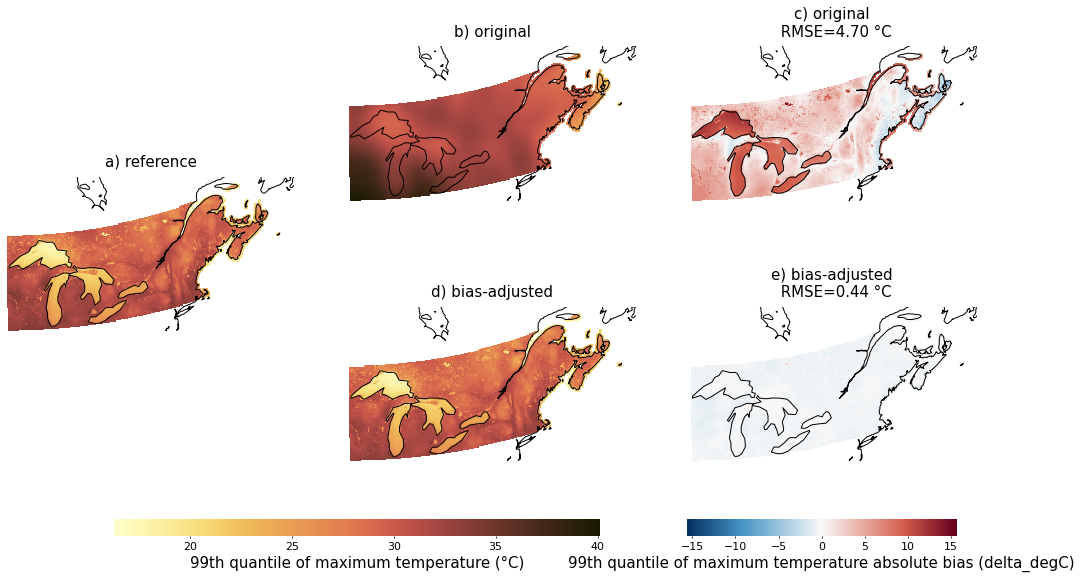

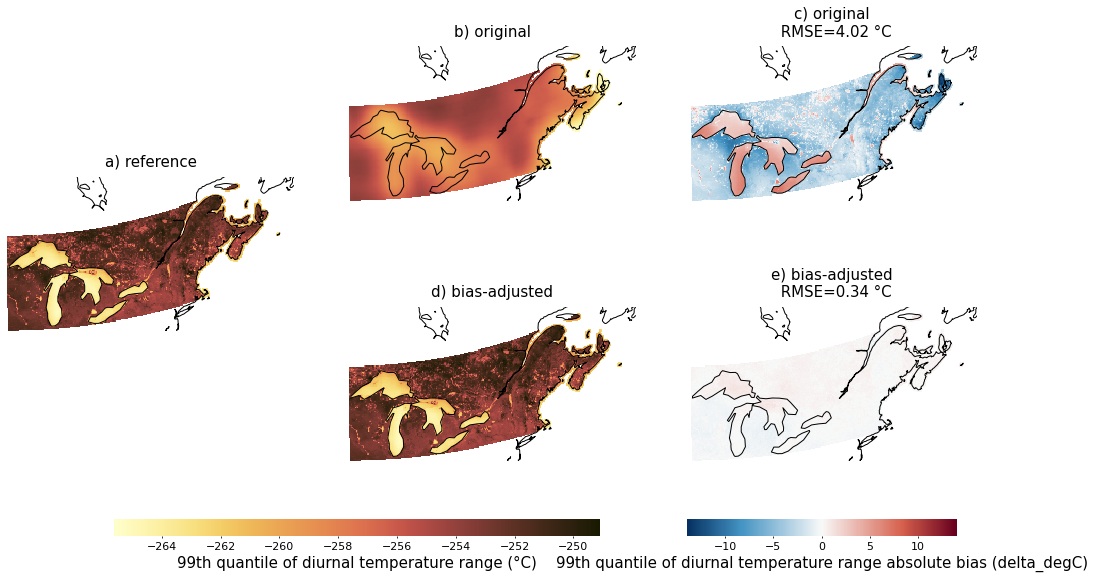

In [156]:
option_id ='CMIP6_ScenarioMIP_MIROC_MIROC6_ssp370_r1i1p1f1_global'
option_region = 'Magtogoek81-rdrs'
option_var = 'q99_tasmax'
fig, axs, cbs=maps(option_id=option_id, option_region=option_region, option_var=option_var)
option_var = 'q99_dtr'
fig, axs, cbs=maps(option_id=option_id, option_region=option_region, option_var=option_var)

/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/tmp/ipykernel_64329/485814466.py:80: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/tmp/ipykernel_64329/485814466.py:88: MatplotlibDeprecationWarning: Auto-removal of g

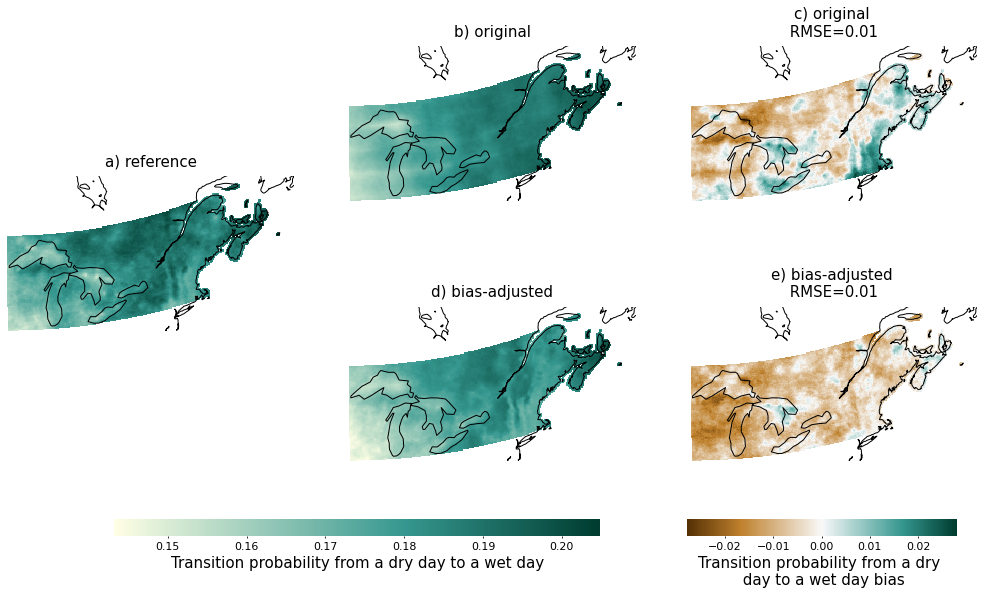

In [32]:
option_id ='CMIP6_ScenarioMIP_CAS_FGOALS-g3_ssp370_r1i1p1f1_global'
option_region = 'Magtogoek81-rdrs'
option_var = 'dry_wet'
fig, axs, cbs=maps(option_id=option_id, option_region=option_region, option_var=option_var)
cbs[1].set_label("Transition probability from a dry \n day to a wet day bias")
cbs[0].set_label("Transition probability from a dry day to a wet day")
plt.savefig(f"{CONFIG['paths']['figures']}dry_wet.eps", format='eps',bbox_inches='tight')

/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/tmp/ipykernel_64329/1001469890.py:80: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/tmp/ipykernel_64329/1001469890.py:88: MatplotlibDeprecationWarning: Auto-removal of

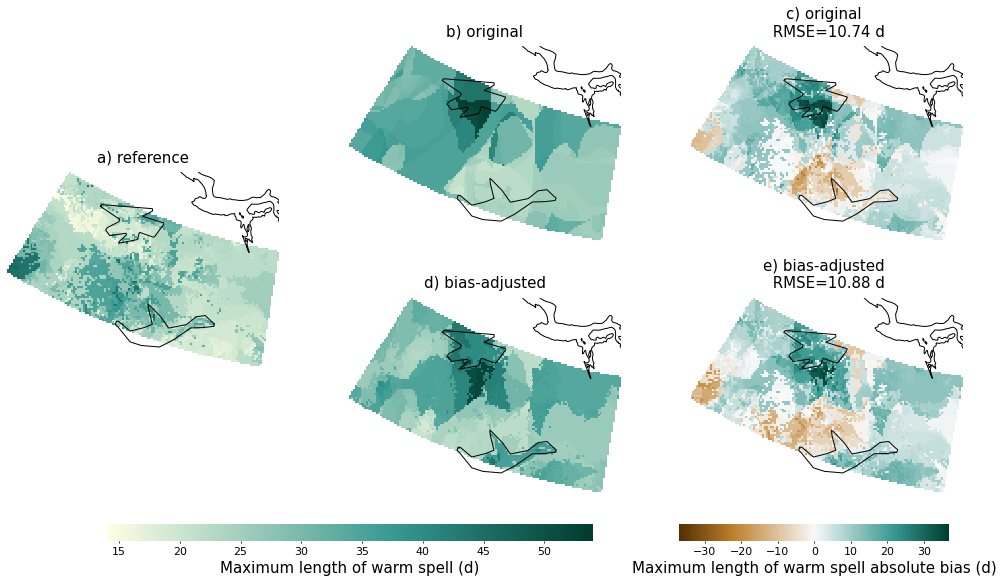

In [113]:
option_id ='CMIP6_ScenarioMIP_CAS_FGOALS-g3_ssp370_r1i1p1f1_global'
option_region = 'Tlicho-rdrs'
option_var = 'max_warm_spell'
fig, axs, cbs=maps(option_id=option_id, option_region=option_region, option_var=option_var)


/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/tmp/ipykernel_64329/1001469890.py:80: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/tmp/ipykernel_64329/1001469890.py:88: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/t

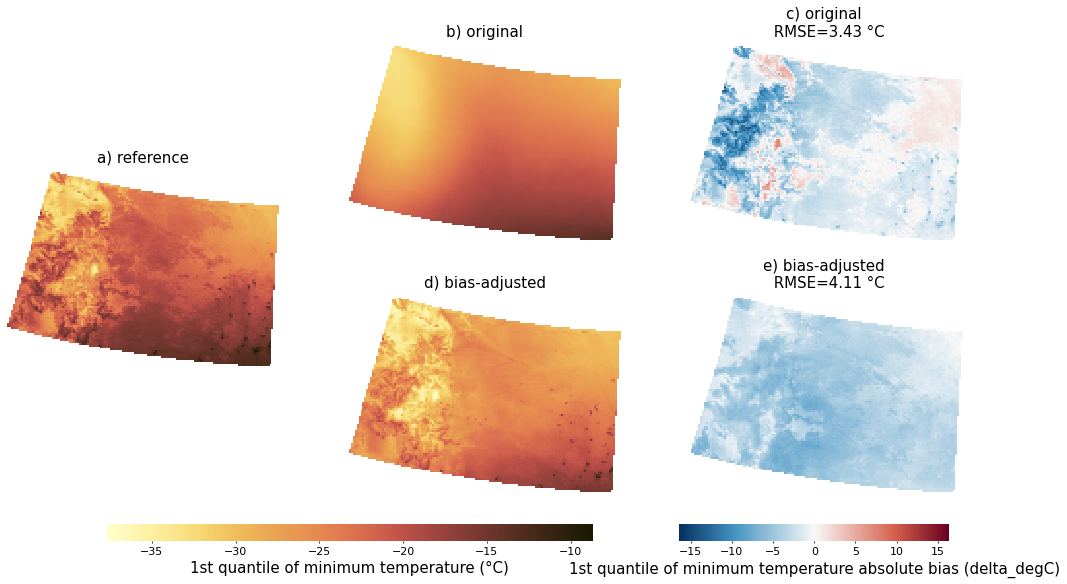

In [155]:
option_id ='CMIP6_ScenarioMIP_BCC_BCC-CSM2-MR_ssp370_r1i1p1f1_global'
option_region = 'UteBig-rdrs'
option_var = 'q01_tasmin'
fig, axs, cbs=maps(option_id=option_id, option_region=option_region, option_var=option_var)


# RMSE table

In [57]:
variables=[ 
        'mean_tasmax','q01_tasmax', 'q99_tasmax', 'mean_tasmin','q01_tasmin','q99_tasmin',
    'mean_dtr', 'q01_dtr','q99_dtr',
    'mean_pr','q95_pr','q99_pr','dry_spell_freq', 
    'aca_tasmax', 'aca_tasmin','aca_pr',
         'max_warm_spell','wet_wet', 'dry_wet', 'max_dry_spell',
        'corr_tasmax_tasmin','corr_tasmax_pr',

        ]
regions = ['Magtogoek81-rdrs', 'Tlicho-rdrs','UteBig-rdrs','Cree-rdrs']


units=[]
r_sim = np.zeros((len(variables),len(hausfather),len(regions)))
r_scen = np.zeros((len(variables),len(hausfather),len(regions)))
for i,option_var in enumerate(variables):
    print(option_var)
    for j, option_source in enumerate(np.sort(hausfather)):
        for k, option_region in enumerate(regions):
            prop_ref = pcat.search( processing_level=['diag-ref-prop*', 'diag_ref_prop'], domain=option_region, variable=option_var).to_dask()[option_var]
            prop_sim = pcat.search(source= option_source, processing_level='diag-sim-prop*', domain=option_region,
                                   variable=option_var, experiment='ssp370').to_dask()[option_var]
            prop_scen = pcat.search(source= option_source, processing_level='diag-scen-prop*', domain=option_region,
                                    variable=option_var, experiment='ssp370').to_dask()[option_var]


            # change units
            if prop_ref.attrs['units']=='kg m-2 s-1':
                prop_ref = xc.core.units.convert_units_to(prop_ref, 'mm d-1', context='hydro')
                prop_sim = xc.core.units.convert_units_to(prop_sim, 'mm d-1', context='hydro')
                prop_scen = xc.core.units.convert_units_to(prop_scen, 'mm d-1', context='hydro')


            if prop_ref.attrs['units']=='K':
                prop_ref = xc.core.units.convert_units_to(prop_ref, 'degC')
                prop_sim = xc.core.units.convert_units_to(prop_sim, 'degC')
                prop_scen = xc.core.units.convert_units_to(prop_scen, 'degC')


            #rmse
            rmse_sim = xr.apply_ufunc(
                _rmse,
                prop_sim.stack(loc=['rlat','rlon']).chunk(dict(loc=-1)),
                prop_ref.stack(loc=['rlat','rlon']).chunk(dict(loc=-1)),
                input_core_dims=[["loc"], ["loc"]],
                dask="parallelized",
            ).values


            rmse_scen = xr.apply_ufunc(
                _rmse,
                prop_scen.stack(loc=['rlat','rlon']).chunk(dict(loc=-1)),
                prop_ref.stack(loc=['rlat','rlon']).chunk(dict(loc=-1)),
                input_core_dims=[["loc"], ["loc"]],
                dask="parallelized",
            ).values


            r_sim[i,j,k]=rmse_sim
            r_scen[i,j,k]=rmse_scen
    units.append(prop_ref.attrs['units'])
#             print(f"{option_source} & {rmse_sim:.2f} & {rmse_scen:.2f}")
#         print(f"avg & {np.mean(r_sim[i]):.2f}& {np.mean(r_scen[i]):.2f}")
#         print('')
ds_rmse=xr.Dataset(data_vars={'sim':(['properties','source','region'],r_sim),
                         'scen':(['properties','source','region'],r_scen)},
                   coords={'properties':variables,
                           'units':(["properties"], units),
                          'source':np.sort(hausfather),
                          'region':regions}
                  )
ds_rmse   

mean_tasmax
q01_tasmax
q99_tasmax
mean_tasmin
q01_tasmin
q99_tasmin
mean_dtr
q01_dtr
q99_dtr
mean_pr
q95_pr
q99_pr
dry_spell_freq
aca_tasmax
aca_tasmin
aca_pr
max_warm_spell
wet_wet
dry_wet
max_dry_spell
corr_tasmax_tasmin
corr_tasmax_pr


<xarray.Dataset>
Dimensions:     (properties: 22, source: 14, region: 4)
Coordinates:
  * properties  (properties) <U18 'mean_tasmax' ... 'corr_tasmax_pr'
    units       (properties) <U10 '°C' '°C' '°C' '°C' '°C' ... '' '' 'd' '' ''
  * source      (source) <U13 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'NorESM2-LM'
  * region      (region) <U16 'Magtogoek81-rdrs' 'Tlicho-rdrs' ... 'Cree-rdrs'
Data variables:
    sim         (properties, source, region) float64 2.37 2.497 ... 0.1547
    scen        (properties, source, region) float64 0.2502 0.4527 ... 0.08951

In [127]:
#print for latex
#print(" & \multicolumn{2}{c||}{Magtogoek} & \multicolumn{2}{c||}{Tlicho} & \multicolumn{2}{c||}{Ute}&\multicolumn{2}{c||}{Cree} \\\ ")
#print('\hline') 
#print(f" & OR & BA & OR & BA & OR & BA & OR & BA \\\ ")
#print('\hline') 
for prop in list(ds_rmse.properties.values):
    unit= str(ds_rmse.sel(properties=prop).units.values).replace('d','days').replace(
        "dayselta_daysegC",r'\textdegree C').replace('°C',r"\textdegree C").replace(
        "mm days-1","mm d$^{-1}$").replace('%',"\%")
    print('')
    prop_str="\multicolumn{9}{|c|}{ \\textbf{"+prop.replace('_','\_')+" ("+unit+")}}\\\ "
    print(prop_str.replace('()',''))
    print('\hline') 



    for source in list(ds_rmse.source.values):
        print(f"{source} ",end="")
        for region in list(ds_rmse.region.values):
            sim = ds_rmse['sim'].sel(properties=prop, source=source, region=region).values
            scen = ds_rmse['scen'].sel(properties=prop, source=source, region=region).values
            if sim < scen:
                print(" & \\textbf{" +f"{sim:.2f}"+ "} & "+f"{scen:.2f}  ", end="")
            elif sim > scen:
                print(" & "+f"{sim:.2f}"+" & \\textbf{" +f"{scen:.2f}"+ "}", end="")
            else:
                print(f" & {sim:.2f} & {scen:.2f} ", end="")
            
        print("\\\ ")
    print('\hline')    
    print(f"average ",end="")
    for region in list(ds_rmse.region.values):
        sim = ds_rmse['sim'].sel(properties=prop,  region=region).mean().values
        scen = ds_rmse['scen'].sel(properties=prop, region=region).mean().values
        if sim < scen:
            print(" & \\textbf{" +f"{sim:.2f}"+ "} & "+f"{scen:.2f}  ", end="")
        elif sim > scen:
            print(" & "+f"{sim:.2f}"+" & \\textbf{" +f"{scen:.2f}"+ "}", end="")
        else:
            print(f" & {sim:.2f} & {scen:.2f} ", end="")
    print("\\\ ")
    print('\hline')



\multicolumn{9}{|c|}{ \textbf{mean\_tasmax (\textdegree C)}}\\ 
\hline
ACCESS-CM2  & 2.37 & \textbf{0.25} & 2.50 & \textbf{0.45} & 3.26 & \textbf{0.18} & 2.50 & \textbf{0.36}\\ 
ACCESS-ESM1-5  & 2.01 & \textbf{0.32} & 1.42 & \textbf{0.23} & 2.61 & \textbf{0.27} & 2.86 & \textbf{0.41}\\ 
BCC-CSM2-MR  & 1.42 & \textbf{0.16} & 0.87 & \textbf{0.21} & 2.07 & \textbf{0.08} & 1.63 & \textbf{0.11}\\ 
CMCC-ESM2  & 2.27 & \textbf{0.24} & 1.97 & \textbf{0.18} & 2.01 & \textbf{0.08} & 1.98 & \textbf{0.20}\\ 
CNRM-ESM2-1  & 1.76 & \textbf{0.20} & 1.70 & \textbf{0.11} & 3.48 & \textbf{0.32} & 1.57 & \textbf{0.24}\\ 
FGOALS-g3  & 1.40 & \textbf{0.43} & 1.61 & \textbf{0.35} & 3.19 & \textbf{0.19} & 1.42 & \textbf{0.31}\\ 
GFDL-ESM4  & 2.24 & \textbf{0.26} & 1.76 & \textbf{0.11} & 2.51 & \textbf{0.20} & 1.61 & \textbf{0.36}\\ 
INM-CM5-0  & 1.39 & \textbf{0.32} & 1.23 & \textbf{0.18} & 2.12 & \textbf{0.27} & 1.58 & \textbf{0.34}\\ 
KACE-1-0-G  & 1.59 & \textbf{0.20} & 1.58 & \textbf{0.51} & 2.59 & \tex

MPI-ESM1-2-LR  & 1.96 & \textbf{0.68} & 1.98 & \textbf{0.44} & 5.39 & \textbf{0.62} & 1.22 & \textbf{0.52}\\ 
MRI-ESM2-0  & 2.12 & \textbf{0.52} & 1.52 & \textbf{0.40} & 2.45 & \textbf{0.71} & 1.01 & \textbf{0.51}\\ 
NorESM2-LM  & 2.99 & \textbf{1.05} & 2.95 & \textbf{1.31} & 5.16 & \textbf{1.58} & \textbf{1.79} & 1.91  \\ 
\hline
average  & 2.30 & \textbf{1.00} & 2.29 & \textbf{0.83} & 3.51 & \textbf{1.15} & 2.17 & \textbf{1.01}\\ 
\hline

\multicolumn{9}{|c|}{ \textbf{mean\_dtr (\textdegree C)}}\\ 
\hline
ACCESS-CM2  & 2.76 & \textbf{0.09} & 2.93 & \textbf{0.06} & 4.70 & \textbf{0.17} & 4.03 & \textbf{0.24}\\ 
ACCESS-ESM1-5  & 3.34 & \textbf{0.07} & 3.46 & \textbf{0.11} & 3.93 & \textbf{0.10} & 2.84 & \textbf{0.11}\\ 
BCC-CSM2-MR  & 2.77 & \textbf{0.07} & 1.43 & \textbf{0.11} & 2.71 & \textbf{0.10} & 1.89 & \textbf{0.08}\\ 
CMCC-ESM2  & 2.39 & \textbf{0.07} & 1.19 & \textbf{0.06} & 4.13 & \textbf{0.12} & 2.97 & \textbf{0.09}\\ 
CNRM-ESM2-1  & 2.41 & \textbf{0.08} & 1.36 & \textbf{0.1

average  & 4.55 & \textbf{1.16} & 2.81 & \textbf{0.73} & 7.04 & \textbf{1.39} & 4.47 & \textbf{0.96}\\ 
\hline

\multicolumn{9}{|c|}{ \textbf{dry\_spell\_freq }}\\ 
\hline
ACCESS-CM2  & 0.07 & \textbf{0.02} & 0.05 & \textbf{0.02} & 0.13 & \textbf{0.01} & 0.13 & \textbf{0.01}\\ 
ACCESS-ESM1-5  & 0.11 & \textbf{0.01} & 0.13 & \textbf{0.01} & 0.13 & \textbf{0.02} & 0.14 & \textbf{0.01}\\ 
BCC-CSM2-MR  & 0.06 & \textbf{0.02} & 0.09 & \textbf{0.01} & 0.09 & \textbf{0.01} & 0.11 & \textbf{0.01}\\ 
CMCC-ESM2  & 0.05 & \textbf{0.02} & 0.07 & \textbf{0.01} & 0.20 & \textbf{0.01} & 0.12 & \textbf{0.01}\\ 
CNRM-ESM2-1  & 0.05 & \textbf{0.02} & 0.06 & \textbf{0.02} & 0.09 & \textbf{0.01} & 0.06 & \textbf{0.01}\\ 
FGOALS-g3  & 0.07 & \textbf{0.02} & 0.08 & \textbf{0.01} & 0.22 & \textbf{0.01} & 0.11 & \textbf{0.01}\\ 
GFDL-ESM4  & 0.11 & \textbf{0.01} & 0.14 & \textbf{0.01} & 0.09 & \textbf{0.01} & 0.13 & \textbf{0.01}\\ 
INM-CM5-0  & 0.11 & \textbf{0.01} & 0.11 & \textbf{0.01} & 0.23 & \textbf{0.0

MRI-ESM2-0  & 8.64 & \textbf{7.08} & 15.75 & \textbf{14.37} & 27.91 & \textbf{14.46} & 28.53 & \textbf{16.71}\\ 
NorESM2-LM  & 6.41 & \textbf{6.33} & 16.11 & \textbf{15.45} & 18.62 & \textbf{15.32} & 21.96 & \textbf{16.04}\\ 
\hline
average  & 7.67 & \textbf{7.23} & 18.58 & \textbf{15.24} & 23.22 & \textbf{17.17} & 24.52 & \textbf{16.16}\\ 
\hline

\multicolumn{9}{|c|}{ \textbf{corr\_tasmax\_tasmin }}\\ 
\hline
ACCESS-CM2  & 0.03 & \textbf{0.01} & 0.02 & \textbf{0.00} & 0.05 & \textbf{0.01} & 0.03 & \textbf{0.00}\\ 
ACCESS-ESM1-5  & 0.03 & \textbf{0.00} & 0.02 & \textbf{0.00} & 0.05 & \textbf{0.01} & 0.04 & \textbf{0.00}\\ 
BCC-CSM2-MR  & 0.02 & \textbf{0.00} & 0.01 & \textbf{0.00} & 0.05 & \textbf{0.01} & 0.03 & \textbf{0.01}\\ 
CMCC-ESM2  & 0.02 & \textbf{0.00} & 0.01 & \textbf{0.00} & 0.04 & \textbf{0.01} & 0.03 & \textbf{0.00}\\ 
CNRM-ESM2-1  & 0.03 & \textbf{0.00} & 0.02 & \textbf{0.00} & 0.04 & \textbf{0.01} & 0.03 & \textbf{0.00}\\ 
FGOALS-g3  & 0.03 & \textbf{0.00} & 0.02 & \te

In [83]:
# latex recap

#print for latex
print('\hline') 
print(" & \multicolumn{2}{c||}{Magtogoek} & \multicolumn{2}{c||}{Tlicho} & \multicolumn{2}{c||}{Ute}&\multicolumn{2}{c||}{Cree} \\\ ")
print('\hline') 
print(f" & OR & BA & OR & BA & OR & BA & OR & BA \\\ ")
print('\hline') 
for prop in list(ds_rmse.properties.values):
    unit= str(ds_rmse.sel(properties=prop).units.values).replace('d','days').replace(
        "dayselta_daysegC",r'\textdegree C').replace('°C',r"\textdegree C").replace(
        "mm days-1","mm d$^{-1}$").replace('%',"/%")
    prop_str=prop.replace('_','\_')+ " ("+unit+")"
    print(prop_str.replace('()',''),end="")
    for region in list(ds_rmse.region.values):
        for var in ['sim','scen']:
            print(f"& {ds_rmse[var].sel(properties=prop, region=region).mean().values:.2f}  ", end="")
    print("\\\ ")
    print('\hline')


\hline
 & \multicolumn{2}{c||}{Magtogoek} & \multicolumn{2}{c||}{Tlicho} & \multicolumn{2}{c||}{Ute}&\multicolumn{2}{c|}{Cree} \\ 
\hline
 & OR & BA & OR & BA & OR & BA & OR & BA \\ 
\hline
mean\_tasmax (\textdegree C)& 1.84  & 0.25  & 1.87  & 0.24  & 2.62  & 0.20  & 1.89  & 0.29  \\ 
\hline
q01\_tasmax (\textdegree C)& 4.06  & 0.67  & 3.10  & 0.59  & 2.97  & 0.40  & 2.67  & 0.45  \\ 
\hline
q99\_tasmax (\textdegree C)& 4.95  & 0.43  & 3.88  & 0.35  & 4.36  & 0.48  & 4.23  & 0.63  \\ 
\hline
mean\_tasmin (\textdegree C)& 2.24  & 0.25  & 2.69  & 0.31  & 3.54  & 0.17  & 2.80  & 0.25  \\ 
\hline
q01\_tasmin (\textdegree C)& 6.05  & 1.84  & 4.04  & 1.34  & 6.25  & 2.49  & 5.71  & 2.02  \\ 
\hline
q99\_tasmin (\textdegree C)& 2.30  & 1.00  & 2.29  & 0.83  & 3.51  & 1.15  & 2.17  & 1.01  \\ 
\hline
mean\_dtr (\textdegree C)& 2.73  & 0.09  & 1.91  & 0.11  & 3.71  & 0.14  & 2.72  & 0.12  \\ 
\hline
q01\_dtr (\textdegree C)& 0.81  & 0.08  & 0.45  & 0.08  & 1.49  & 0.16  & 0.72  & 0.10  \\ 
\hli

# heatmap


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "long_name" not found.


q95_pr 0.8780528
aca_pr 0.71886075
aca_tasmax 0.9277436
maximum_length_of_warm_spell 0.81451386
maximum_length_of_dry_spell 0.73481905
wet_wet_transition 0.8487834
dry_wet_transition 0.6250867
corr_tasmax_tasmin 0.9267295
corr_tasmax_pr 0.8919007

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "long_name" not found.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "long_name" not found.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "long_name" not found.


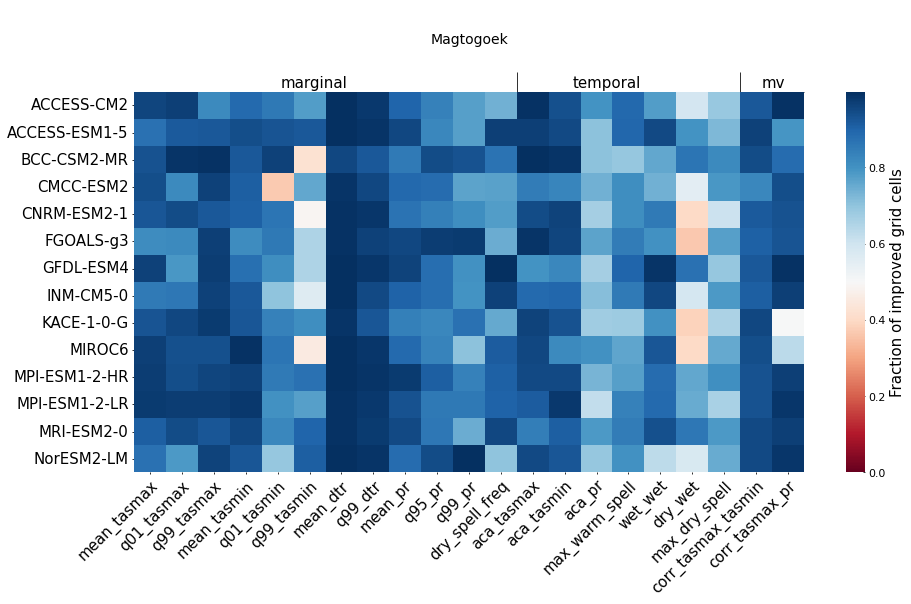

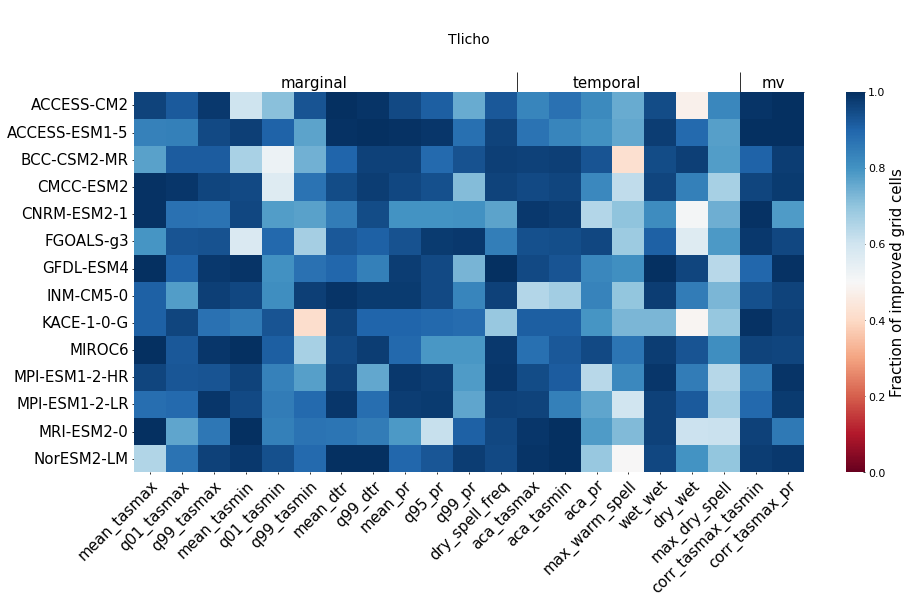

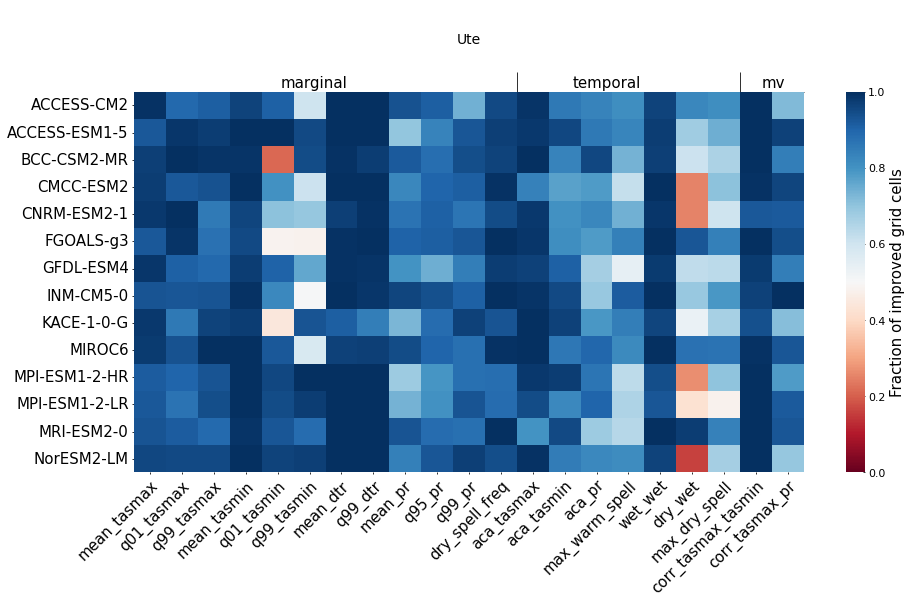

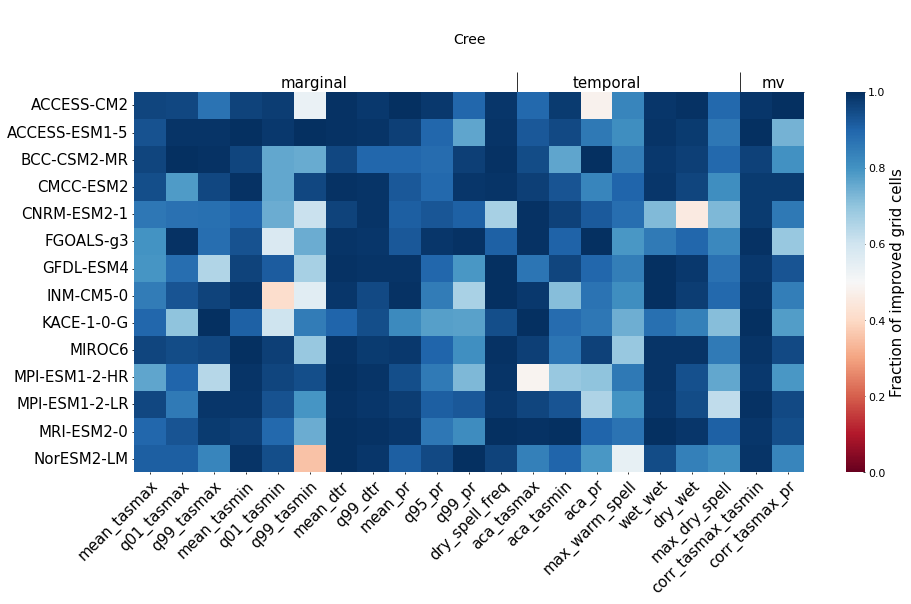

In [163]:
#assemble all improved into 1 dataset
for domain in ['Magtogoek81-rdrs', 'Tlicho-rdrs','UteBig-rdrs','Cree-rdrs']:
    dict_hm = pcat.search(processing_level='diag-improved', domain= domain, experiment='ssp370').to_dataset_dict()
    dict_hm= {ds.attrs['cat:source']:ds for name,ds in dict_hm.items()}
    ds_merge=xs.diagnostics.measures_improvement_2d(dict_hm)

    order = [
            'mean_tasmax','q01_tasmax', 'q99_tasmax', 'mean_tasmin','q01_tasmin','q99_tasmin', 
        'mean_dtr', 'q99_dtr',
        'mean_pr','q95_pr','q99_pr','dry_spell_freq', 
        'aca_tasmax', 'aca_tasmin','aca_pr',
             'max_warm_spell','wet_wet', 'dry_wet', 'max_dry_spell',
            'corr_tasmax_tasmin','corr_tasmax_pr',
            ]
    # put in the right order
    ds_merge= ds_merge.sel(properties=order, realization = np.sort(ds_merge.realization.values))


    ax=sp.heatmap(ds_merge, fig_kw={'figsize':(15,7)},divergent=0.5 , plot_kw={'vmin': 0})
    ax.set_xlabel("") # get rid of labels
    ax.set_ylabel("")
    plt.xticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)


    y=1.025
    plt.annotate(r"marginal",fontsize=15,xy=(0.26, y), xycoords='figure fraction')
    plt.annotate(r"temporal",fontsize=15,xy=(0.53, y), xycoords='figure fraction')
    plt.annotate(r"mv",fontsize=15,xy=(0.705, y), xycoords='figure fraction')
    ax2 = plt.gca().secondary_xaxis('top')
    ax2.tick_params(axis='x',length=20, direction="out")
    ax2.set_xticks([12,19])
    plt.setp(ax2.get_xticklabels(), visible=False)


    #cb = plt.colorbar()
    ax.collections[-1].colorbar.set_label(label='Fraction of improved grid cells',size=15)
    ax.set_title(domain.replace('-rdrs','').replace('81','').replace('Big',''),y =1.1)
    plt.savefig(f"{CONFIG['paths']['figures']}imp_{domain}.eps", format='eps',bbox_inches='tight')
    if domain =='Magtogoek81-rdrs':
        # get mean IMP 
        print('q95_pr',ds_merge.sel(properties='q95_pr').improved_grid_points.mean(dim='realization').values)
        print('aca_pr',ds_merge.sel(properties='aca_pr').improved_grid_points.mean(dim='realization').values)
        print('aca_tasmax', ds_merge.sel(properties='aca_tasmax').improved_grid_points.mean(dim='realization').values)

        print('maximum_length_of_warm_spell',ds_merge.sel(properties='max_warm_spell').improved_grid_points.mean(dim='realization').values)
        print('maximum_length_of_dry_spell',ds_merge.sel(properties='max_dry_spell').improved_grid_points.mean(dim='realization').values)
        print('wet_wet_transition',ds_merge.sel(properties='wet_wet').improved_grid_points.mean(dim='realization').values)
        print('dry_wet_transition',ds_merge.sel(properties='dry_wet').improved_grid_points.mean(dim='realization').values)

        print('corr_tasmax_tasmin',ds_merge.sel(properties='corr_tasmax_tasmin').improved_grid_points.mean(dim='realization').values)
        print('corr_tasmax_pr',ds_merge.sel(properties='corr_tasmax_pr').improved_grid_points.mean(dim='realization').values)

# Domain

/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/xscen/spatial.py:185: UserWarning: Loading longitude and latitude for more efficient subsetting.


(126, 244)
(100, 140)
(100, 140)
(100, 140)


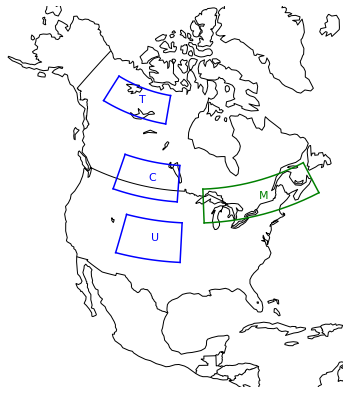

In [5]:
# This is the map projection we want to plot *onto*
import matplotlib.patches as mpatches
import cartopy
map_proj = ccrs.RotatedPole(pole_longitude=87.59703063964844,
                          pole_latitude=31.758316040039062,
                         )

# something to plot as the domain
ds = pcat.search(processing_level='ensemble-climatology', domain='NAM-rdrs',xrfreq='AS-JAN',
                 variable='tg_mean_p50', experiment='ssp370').to_dataset().sel(time='1989-01-01')['tg_mean_p50']

ds = xc.core.units.convert_units_to(ds,'degC')
ds=ds.where(ds>1e12)
provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
     name='admin_1_states_provinces_lines', scale='110m', facecolor='none', edgecolor='k')

ax= sp.gridmap(ds.squeeze(),
               fig_kw=dict(figsize=(10,7)),
               projection=map_proj,
               plot_kw={'add_colorbar':False},
               #show_time=True, TODO: add when can choose loc
               features={'coastline':{'scale':'110m'},
                         #"admin_1_states_provinces_lines":{'scale':'110m'},
                         'lakes':{'scale':'110m','edgecolor':'black','facecolor':'none'}}
              )

country_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
     name='admin_0_boundary_lines_land', scale='50m', facecolor='none', edgecolor='k')
# provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
#      name='admin_1_states_provinces_lines', scale='50m', facecolor='none', edgecolor='k')

# ax.add_feature(provinc_bodr)
ax.add_feature(country_bodr )



def _plot_rectangle(ax, lat_bnds, lon_bnds, color='green'):

    ax.plot(np.linspace(lon_bnds[0], lon_bnds[1],15), np.linspace(lat_bnds[0], lat_bnds[0],15),
             color=color, linestyle='-', transform=ccrs.PlateCarree()
             )

    ax.plot(np.linspace(lon_bnds[0], lon_bnds[1],15), np.linspace(lat_bnds[1], lat_bnds[1],15),
             color=color, linestyle='-',transform=ccrs.PlateCarree()
             )

    ax.plot(np.linspace(lon_bnds[0], lon_bnds[0],15), np.linspace(lat_bnds[0], lat_bnds[1],15),
             color=color, linestyle='-',transform=ccrs.PlateCarree()
             )

    ax.plot(np.linspace(lon_bnds[1], lon_bnds[1],15), np.linspace(lat_bnds[0], lat_bnds[1],15),
             color=color, linestyle='-',transform=ccrs.PlateCarree()
             )

#rectangle for spatial subregion magtogoek-rdrs
lat_bnds=  [ 43, 49.4]  
lon_bnds= [ -90, -59.8 ] 
print(xs.spatial.subset(ds, name='test', method='bbox', lat_bnds=lat_bnds, lon_bnds=lon_bnds).shape)
_plot_rectangle(ax, lat_bnds, lon_bnds)
ax.text(np.mean(lon_bnds),np.mean(lat_bnds), 'M', color='green',transform=ccrs.PlateCarree())

# colorado, 37°N to 41°N latitude, and from 102°02'48"W to 109°02'48"W - Ute (big)
lat_bnds=  [ 35.5, 43]  
lon_bnds= [ -109.6, -95.5 ]
print(xs.spatial.subset(ds, name='test', method='bbox', lat_bnds=lat_bnds, lon_bnds=lon_bnds).shape)
_plot_rectangle(ax, lat_bnds, lon_bnds, color='blue')
ax.text(np.mean(lon_bnds),np.mean(lat_bnds), 'U', color='blue',transform=ccrs.PlateCarree())


# prairies - Cree
lat_bnds=  [ 46.9, 53.8]  
lon_bnds= [ -115, -97.1 ]
print(xs.spatial.subset(ds, name='test', method='bbox', lat_bnds=lat_bnds, lon_bnds=lon_bnds).shape)
_plot_rectangle(ax, lat_bnds, lon_bnds, color='blue')
ax.text(np.mean(lon_bnds),np.mean(lat_bnds), 'C', color='blue',transform=ccrs.PlateCarree())


#nord - Tlicho
lat_bnds=  [ 61.3, 66.75]  
lon_bnds= [ -130, -103.8 ]
print(xs.spatial.subset(ds, name='test', method='bbox', lat_bnds=lat_bnds, lon_bnds=lon_bnds).shape)
_plot_rectangle(ax, lat_bnds, lon_bnds, color='blue')
ax.text(np.mean(lon_bnds),np.mean(lat_bnds), 'T', color='blue',transform=ccrs.PlateCarree())




#ax.collections[-1].colorbar.outline.set_visible(False)
ax.set_title('')
#ax.collections[-1].colorbar.set_label(r'1989-2018 mean temperature ($^{\circ}$C)')
plt.savefig(f"{CONFIG['paths']['figures']}domain.pdf",bbox_inches='tight')

# ensemble variability


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "None" not found.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "None" not found.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "None" not found.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:633: UserWarning: No spaces, points or colons to break line at.


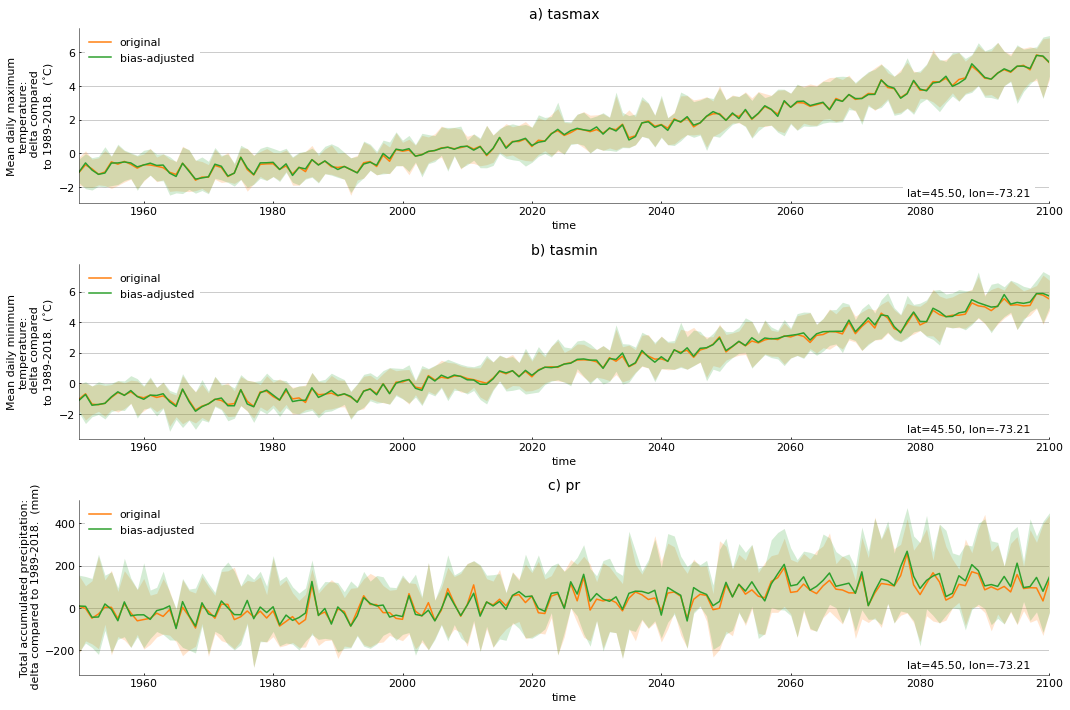

In [ ]:
lat= 45.5
lon=-73.5
lat=45.503895
var = 'tx_mean'

func= {'prcptot': 'precip_accumulation',
      'tx_mean':'tx_mean',
      'tn_mean':'tn_mean'}
fig, axs = plt.subplots(3,1, figsize=(15,10))
with xr.set_options(keep_attrs=True):
    for i,(var,title) in enumerate(zip(['tx_mean', 'tn_mean', 'prcptot'],['a) tasmax','b) tasmin', 'c) pr'])):
        #get variable and compute indicators
        sim_dict = pcat.search(processing_level='regridded', experiment='ssp370', domain ='QC-rdrs').to_dataset_dict()    
        sim_dict= {i: getattr(xc.atmos, func[var])(ds=ds.where(ds.lat==lat, drop=True)).drop_vars('loc').squeeze()
                   for i,ds in sim_dict.items()}
        # compute anomaly
        sim_dict = {i: ds - ds.sel(time=slice('1989','2018')).mean(dim='time') for i,ds in sim_dict.items()}
        # ensemble stats
        ens_sim = xs.ensembles.ensemble_stats(
                            datasets=sim_dict,
                            statistics={"ensemble_percentiles": {'split': False}},
                            common_attrs_only=False,
                        )[var].to_dataset()


        #same as above but for scen
        scen_dict = pcat.search(processing_level='indicators', domain='QC-rdrs',
                                variable=var, xrfreq='AS-JAN', experiment='ssp370').to_dataset_dict()
        scen_dict = {i: ds.where(ds.lat==lat, drop=True).squeeze() for i,ds in scen_dict.items()}
        scen_dict = {i: ds - ds.sel(time=slice('1989','2018')).mean(dim='time') for i,ds in scen_dict.items()}
        ens_scen = xs.ensembles.ensemble_stats(
                            datasets=scen_dict,
                            statistics={"ensemble_percentiles": {'split': False}},
                            common_attrs_only=False,
                        )[var].to_dataset()
        
        ens_sim[var].attrs['long_name']= f"{ens_sim[var].attrs['long_name']}:\n delta compared to 1989-2018. "

        if var in ['tx_mean', 'tn_mean']:
            ens_sim[var].attrs['units']=r"$^{\circ}$C"
        
        sp.timeseries({'original': ens_sim[var], 'bias-adjusted': ens_scen[var]},
                  ax =axs[i],
                  use_attrs={'title':None},
                  plot_kw={'original': {'color':'tab:orange',}, 'bias-adjusted': {'color':'tab:green'}})

        sns.move_legend(axs[i], loc='upper left', )
        axs[i].set_title(title, loc='center')
    fig.tight_layout()
plt.savefig(f"{CONFIG['paths']['figures']}ens_var.pdf",bbox_inches='tight')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.


tx_mean 0.34976647440590647

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.


tn_mean 0.132672775689433

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.


prcptot 0.3521340740026614


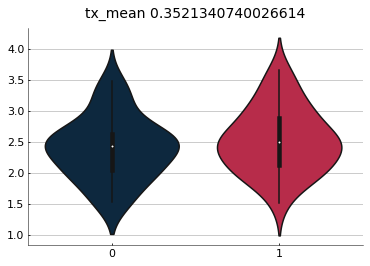

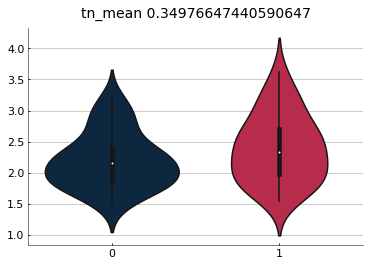

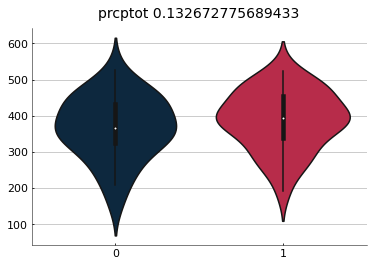

In [13]:
# f test
import scipy
def get_pvalue(group1, group2 ):
    
    # check if they have the same variance, F-test
    f = np.var(group1, ddof=1)/np.var(group2, ddof=1)
    nun = len(group1)-1
    dun = len(group2)-1
    p_value = 1-scipy.stats.f.cdf(f, nun, dun)
    if p_value >= 0.05:
        equal_var=  True 
    else:
        equal_var = False 
    
    # T-test
    pvalue=scipy.stats.ttest_ind(group1,group2, equal_var =equal_var , nan_policy='omit').pvalue
    
    return pvalue

lat= 45.5
lon=-73.5
lat=45.503895

func= {'prcptot': 'precip_accumulation',
      'tx_mean':'tx_mean',
      'tn_mean':'tn_mean'}
with xr.set_options(keep_attrs=True):
    for i,(var,title) in enumerate(zip(['tx_mean', 'tn_mean', 'prcptot'],['a)','b)', 'c)'])):
        #get variable and compute indicators
        sim_dict = pcat.search(processing_level='regridded', experiment='ssp370', domain ='QC-rdrs').to_dataset_dict()    
        sim_dict= {i: getattr(xc.atmos, func[var])(ds=ds.where(ds.lat==lat, drop=True)).drop_vars('loc').squeeze()
                   for i,ds in sim_dict.items()}
        # compute anomaly
        sim_dict = {i: ds - ds.sel(time=slice('1989','2018')).mean(dim='time') for i,ds in sim_dict.items()}
        # ensemble stats
        ens_sim = xs.ensembles.ensemble_stats(
                            datasets=sim_dict,
                            statistics={"ensemble_percentiles": {'split': False}},
                            common_attrs_only=False,
                        )[var].to_dataset()


        #same as above but for scen
        scen_dict = pcat.search(processing_level='indicators', domain='QC-rdrs',
                                variable=var, xrfreq='AS-JAN', experiment='ssp370').to_dataset_dict()
        scen_dict = {i: ds.where(ds.lat==lat, drop=True).squeeze() for i,ds in scen_dict.items()}
        scen_dict = {i: ds - ds.sel(time=slice('1989','2018')).mean(dim='time') for i,ds in scen_dict.items()}
        ens_scen = xs.ensembles.ensemble_stats(
                            datasets=scen_dict,
                            statistics={"ensemble_percentiles": {'split': False}},
                            common_attrs_only=False,
                        )[var].to_dataset()
        
        group_sim = (ens_sim.sel(percentiles=90) - ens_sim.sel(percentiles=10)).sel(time=slice('2071','2100'))
        group_scen = (ens_scen.sel(percentiles=90)-ens_scen.sel(percentiles=10)).sel(time=slice('2071','2100'))
        plt.figure()
        sns.violinplot(data =[group_sim[var],group_scen[var]])
        plt.title(f"{var} {p}")
        p=get_pvalue(group_sim[var].values, group_scen[var].values )
        print(var, p)
        

# delta

In [146]:

# mediane des deltas NAM, sim et scen. with percentage delta for pr

hausfather =['MIROC6','CMCC-ESM2', 'FGOALS-g3', 'ACCESS-CM2', 'ACCESS-ESM1-5', 'MPI-ESM1-2-HR', 'INM-CM5-0',
     'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorESM2-LM', 'KACE-1-0-G', 'CNRM-ESM2-1', 'GFDL-ESM4', 'BCC-CSM2-MR']

# sim
ds_reg_dict = pcat.search(processing_level='ensemble-reg-abs-delta-1989-2018', xrfreq='AS-JAN').to_dataset_dict()
regs=[]
for region in ['south', 'middle', 'north']:
    regs.append(xs.utils.unstack_fill_nan(
        ds_reg_dict[f'CMIP6_ScenarioMIP_ssp370_{region}-rdrs-rot.{region}-rdrs-rot.ensemble-reg-abs-delta-1989-2018.AS-JAN']))
ds_reg = xr.concat(regs, 'rlat')


#sim pr 
ds_reg_dict = pcat.search(processing_level='ensemble-reg-per-delta-1989-2018', xrfreq='AS-JAN').to_dataset_dict()
regs=[]
for region in ['south', 'middle', 'north']:
    regs.append(xs.utils.unstack_fill_nan(
        ds_reg_dict[f'CMIP6_ScenarioMIP_ssp370_{region}-rdrs-rot.{region}-rdrs-rot.ensemble-reg-per-delta-1989-2018.AS-JAN']))
ds_reg_per = xr.concat(regs, 'rlat')

#scen
ds = pcat.search(processing_level='ensemble-abs-delta-1989-2018', xrfreq='AS-JAN', domain='NAM-rdrs',
                 experiment='ssp370').to_dataset()

#scen pr
ds_per = pcat.search(processing_level='ensemble-per-delta-1989-2018', xrfreq='AS-JAN', domain='NAM-rdrs',
                    experiment='ssp370').to_dataset()


map_proj = ccrs.RotatedPole(pole_longitude=87.59703063964844,
                          pole_latitude=31.758316040039062,
                         )

p='p50'
fig, axs= plt.subplots(3,3, figsize=(20,30),subplot_kw={'projection': map_proj})


for i,(var, long_var, variable) in enumerate(zip(['tx_mean', 'tn_mean', 'prcptot'],
                                       ['mean daily maximum temperature',
                                        'mean daily minimum temperature',
                                        'total accumulated precipitation',],
                                                ['tasmax','tasmin','pr'])):
    if var =='prcptot':
        da=ds_per[f"{var}_delta_1989_2018_{p}"].sel(time='2071').squeeze().chunk({'rlat':-1, 'rlon':-1})
        da_reg=ds_reg_per[f"{var}_delta_1989_2018_{p}"].sel(time='2071').squeeze().chunk({'rlat':-1, 'rlon':-1})
        diff = da-da_reg

    else:
        
        da=ds[f"{var}_delta_1989_2018_{p}"].sel(time='2071').squeeze().chunk({'rlat':-1, 'rlon':-1})
        da_reg=ds_reg[f"{var}_delta_1989_2018_{p}"].sel(time='2071').squeeze().chunk({'rlat':-1, 'rlon':-1})
        diff = da-da_reg
    diff.attrs['long_name']=da.attrs['long_name']
    shrink=0.5
    if var =='tx_mean':
        da.attrs['units']=r"$^{\circ}$C"
        da_reg.attrs['units']=r"$^{\circ}$C"
        diff.attrs['units']=r"$^{\circ}$C"
        sp.gridmap(da_reg, ax=axs[0,i], cmap='Reds', plot_kw=dict(vmin=0, vmax=8,cbar_kwargs={'shrink':shrink}))
        sp.gridmap(da, ax=axs[1,i],  cmap='Reds', plot_kw=dict(vmin=0, vmax=8,cbar_kwargs={'shrink':shrink}))
        sp.gridmap(diff, ax=axs[2,i], divergent=0,cmap='misc_div', plot_kw=dict(cbar_kwargs={'shrink':shrink}))
        
    elif var =='tn_mean':
        da.attrs['units']=r"$^{\circ}$C"
        da_reg.attrs['units']=r"$^{\circ}$C"
        diff.attrs['units']=r"$^{\circ}$C"
        sp.gridmap(da_reg, ax=axs[0,i], cmap='Reds', plot_kw=dict(vmin=0, vmax=9.5,cbar_kwargs={'shrink':shrink}))
        sp.gridmap(da, ax=axs[1,i], cmap='Reds', plot_kw=dict(vmin=0, vmax=9.5,cbar_kwargs={'shrink':shrink}))
        sp.gridmap(diff, ax=axs[2,i], divergent=0,cmap='misc_div', plot_kw=dict(cbar_kwargs={'shrink':shrink}))

    else:
        diff.attrs['units'] =da_reg.attrs['units']
        sp.gridmap(da_reg, ax=axs[0,i], divergent=0, plot_kw=dict(vmin=-70, vmax=70,cbar_kwargs={'shrink':shrink}))
        sp.gridmap(da, ax=axs[1,i], divergent=0, plot_kw=dict(vmin=-70, vmax=70,cbar_kwargs={'shrink':shrink}))
        sp.gridmap(diff, ax=axs[2,i], divergent=0,cmap='misc_div', plot_kw=dict(cbar_kwargs={'shrink':shrink}))

    
    



    
#     axs[2,i].collections[-1].colorbar.outline.set_visible(False)
#     axs[2,i].set_title(f'{string.ascii_lowercase[i+ (3*j)]}) '+ rf'$\tt{variable}$', fontsize=20)
#     axs[2,i].collections[-1].colorbar.set_label(
#             f"Delta of the annual {long_var}\n ({da.attrs['units']})", fontsize=18)
    print('sim')
    print(var, da_reg.mean().values)
    print('scen')
    print(var, da.mean().values)
    
    
    # hatching
    

    ens_clim_reg = pcat.search(processing_level='reg-abs-delta-1989-2018', experiment='ssp370',
                     xrfreq='AS-JAN', domain='south-rdrs-rot',source=hausfather,
                     variable=f'{var}_delta_1989_2018',
                    ).to_dataset_dict()
    ens_clim_reg= xc.ensembles.create_ensemble(ens_clim_reg)
    ens_clim_reg= xs.utils.unstack_fill_nan(ens_clim_reg).sel(time='2071')
    chng_f, pos_f_reg = xc.ensembles.change_significance(ens_clim_reg, test="threshold", abs_thresh=0.001)
    no_agree_reg= pos_f_reg.where(pos_f_reg[f'{var}_delta_1989_2018']<0.8).where(
        0.2<pos_f_reg[f'{var}_delta_1989_2018'])
    sp.hatchmap({'no agreement':no_agree_reg.squeeze()}, ax=axs[0,i],plot_kw= {'no agreement':{'hatches': '/'}})
    sp.hatchmap({'no agreement':no_agree_reg.squeeze()}, ax=axs[2,i],plot_kw= {'no agreement':{'hatches': '/'}})

    


    ens_clim = pcat.search(processing_level='abs-delta-1989-2018', experiment='ssp370',
                     xrfreq='AS-JAN', domain='NAM-rdrs',source=hausfather,
                     variable=f'{var}_delta_1989_2018',
                    ).to_dataset_dict()
    ens_clim= xc.ensembles.create_ensemble(ens_clim).sel(time='2071')
    chng_f, pos_f = xc.ensembles.change_significance(ens_clim, test="threshold", abs_thresh=0.001)
    no_agree= pos_f.where(pos_f[f'{var}_delta_1989_2018']<0.8).where(0.2<pos_f[f'{var}_delta_1989_2018'])
    sp.hatchmap({'no agreement':no_agree.squeeze()}, ax=axs[1,i],plot_kw= {'no agreement':{'hatches': "\\"}})
    sp.hatchmap({'no agreement':no_agree.squeeze()}, ax=axs[2,i],plot_kw= {'no agreement':{'hatches': "\\"}})

    
    #no_agree_diff= no_agree.where(no_agree_reg)
    #sp.hatchmap({'no agreement':no_agree_diff.squeeze()}, ax=axs[2,i],plot_kw= {'no agreement':{'hatches': 'x'}})
    axs[1,i].get_legend().remove()
    axs[0,i].get_legend().remove()
    axs[2,i].get_legend().remove()
    
    for j in range(3):
        #axs[j,i].collections[-1].colorbar.outline.set_visible(False)
        axs[j,i].set_title(f'{string.ascii_lowercase[i+ (3*j)]}) '+ rf'$\tt{variable}$', fontsize=20)
        axs[j,i].collections[0].colorbar.set_label(
            f"Delta of the annual {long_var}\n ({da.attrs['units']})", fontsize=18)



fig.text(-0.05,0.77,r'original', fontsize=25, rotation='vertical')
fig.text(-0.05,0.47,r'bias-adjusted', fontsize=25, rotation='vertical')
fig.text(-0.05,0.15,r'bias-adjusted - original', fontsize=25, rotation='vertical')

fig.tight_layout(h_pad=-15)
fig.suptitle('Median of the Ensemble', fontsize=30, y=0.96)
plt.savefig(f"{CONFIG['paths']['figures']}delta_p50.pdf", bbox_inches='tight')
plt.savefig(f"{CONFIG['paths']['figures']}delta_p50.png", bbox_inches='tight') # for overleaf


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.utils:Dataset unstacked using /jarre/scenario/jlavoie/ESPO-G6/coords/coords_south-rdrs-rot_258x706.nc.
INFO:xscen.utils:Dataset unstacked using /jarre/scenario/jlavoie/ESPO-G6/coords/coords_middle-rdrs-rot_267x706.nc.
INFO:xscen.utils:Dataset unstacked using /jarre/scenario/jlavoie/ESPO-G6/coords/coords_north-rdrs-rot_275x706.nc.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.utils:Dataset unstacked using /jarre/scenario/jlavoie/ESPO-G6/coords/coords_south-rdrs-rot_258x706.nc.
INFO:xscen.utils:Dataset unstacked using /jarre/scenario/jlavoie/ESPO-G6/coords/coords_middle-rdrs-rot_267x706.nc.
INFO:xscen.utils:Dataset unstacked using /jarre/scenario/jlavoie/ESPO-G6/coords/coords_north-rdrs-rot_275x706.nc.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:851: UserWarning: No spaces, points or colons to break line at.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:851: UserWarning: No spaces, points or colons to break line at.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.


sim
tx_mean 4.1259456
scen
tx_mean 4.0810795

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.utils:Dataset unstacked using /jarre/scenario/jlavoie/ESPO-G6/coords/coords_south-rdrs-rot_258x706.nc.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 56
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 56
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/plot.py:1926: UserWarning: Only first variable of Dataset is plotted.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:816: UserWarning: Rotated pole not found. Specify a transform if necessary.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/matplotlib/contour.py:1486: UserWarning: Warning: converting a masked element to nan.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/matplotlib/contour.py:1487: UserWarning: Warning: converting a masked element to 


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/plot.py:1926: UserWarning: Only first variable of Dataset is plotted.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:816: UserWarning: Rotated pole not found. Specify a transform if necessary.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/plot.py:1926: UserWarning: Only first variable of Dataset is plotted.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:816: UserWarning: Rotated pole not found. Specify a transform if necessary.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:851: UserWarning: 

sim
tn_mean 4.3086166
scen
tn_mean 4.3089204

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.utils:Dataset unstacked using /jarre/scenario/jlavoie/ESPO-G6/coords/coords_south-rdrs-rot_258x706.nc.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 56
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 56
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/plot.py:1926: UserWarning: Only first variable of Dataset is plotted.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:816: UserWarning: Rotated pole not found. Specify a transform if necessary.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/matplotlib/contour.py:1486: UserWarning: Warning: converting a masked element to nan.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/matplotlib/contour.py:1487: UserWarning: Warning: converting a masked element to 


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/plot.py:1926: UserWarning: Only first variable of Dataset is plotted.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:816: UserWarning: Rotated pole not found. Specify a transform if necessary.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/plot.py:1926: UserWarning: Only first variable of Dataset is plotted.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:816: UserWarning: Rotated pole not found. Specify a transform if necessary.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: 

sim
prcptot 9.934584
scen
prcptot 12.394262

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.utils:Dataset unstacked using /jarre/scenario/jlavoie/ESPO-G6/coords/coords_south-rdrs-rot_258x706.nc.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 56
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 56
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/plot.py:1926: UserWarning: Only first variable of Dataset is plotted.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:816: UserWarning: Rotated pole not found. Specify a transform if necessary.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/plot.py:1926: UserWarning: Only first variable of Dataset is plotte


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/plot.py:1926: UserWarning: Only first variable of Dataset is plotted.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:816: UserWarning: Rotated pole not found. Specify a transform if necessary.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/plot.py:1926: UserWarning: Only first variable of Dataset is plotted.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:816: UserWarning: Rotated pole not found. Specify a transform if necessary.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:216: UserWarning: Attribute "description" not found.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.utils:Dataset unstacked using /jarre/scenario/jlavoie/ESPO-G6/coords/coords_south-rdrs-rot_258x706.nc.
INFO:xscen.utils:Dataset unstacked using /jarre/scenario/jlavoie/ESPO-G6/coords/coords_middle-rdrs-rot_267x706.nc.
INFO:xscen.utils:Dataset unstacked using /jarre/scenario/jlavoie/ESPO-G6/coords/coords_north-rdrs-rot_275x706.nc.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.utils:Dataset unstacked using /jarre/scenario/jlavoie/ESPO-G6/coords/coords_south-rdrs-rot_258x706.nc.
INFO:xscen.utils:Dataset unstacked using /jarre/scenario/jlavoie/ESPO-G6/coords/coords_middle-rdrs-rot_267x706.nc.
INFO:xscen.utils:Dataset unstacked using /jarre/scenario/jlavoie/ESPO-G6/coords/coords_north-rdrs-rot_275x706.nc.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:851: UserWarning: No spaces, points or colons to break line at.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:851: UserWarning: No spaces, points or colons to break line at.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:851: UserWarning: No spaces, points or colons to break line at.


sim
tx_mean 1.9865065
scen
tx_mean 2.0019784


/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:851: UserWarning: No spaces, points or colons to break line at.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:851: UserWarning: No spaces, points or colons to break line at.
/exec/jlavoie/.conda/espo-fig/lib/python3.9/site-packages/figanos/matplotlib/utils.py:851: UserWarning: No spaces, points or colons to break line at.


sim
tn_mean 1.8671832
scen
tn_mean 1.8941662
sim
prcptot 17.446905
scen
prcptot 18.436264


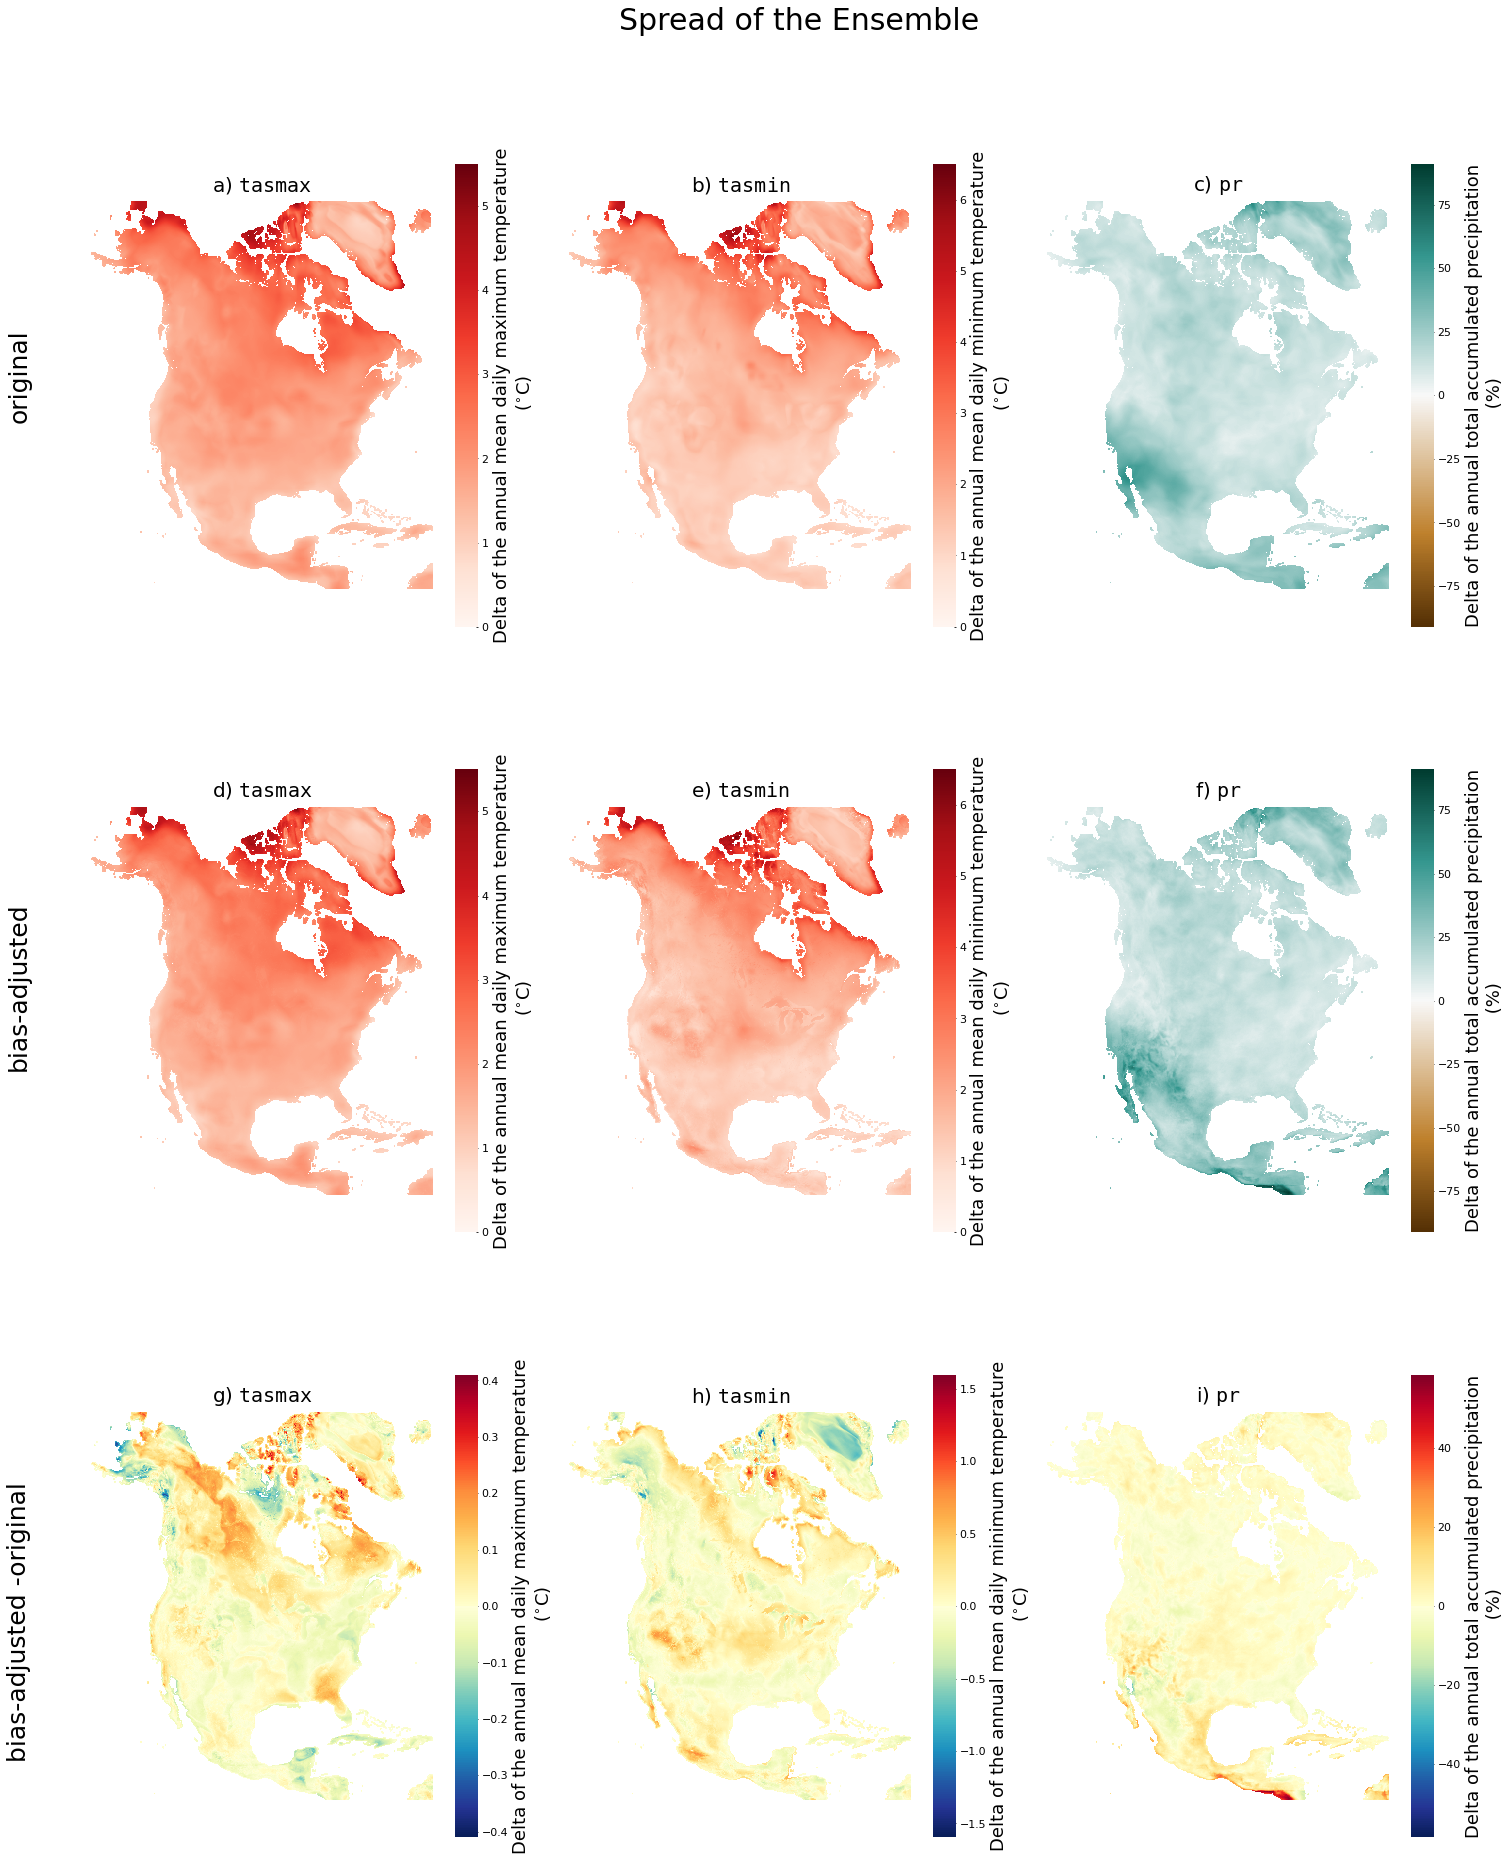

In [144]:
# # spread des deltas NAM, sim et scen


ds_reg_dict = pcat.search(processing_level='ensemble-reg-abs-delta-1989-2018', xrfreq='AS-JAN', experiment='ssp370').to_dataset_dict()
regs=[]
for region in ['south', 'middle', 'north']:
    regs.append(xs.utils.unstack_fill_nan(
        ds_reg_dict[f'CMIP6_ScenarioMIP_ssp370_{region}-rdrs-rot.{region}-rdrs-rot.ensemble-reg-abs-delta-1989-2018.AS-JAN']))
ds_reg = xr.concat(regs, 'rlat')


#sim pr 
ds_reg_dict = pcat.search(processing_level='ensemble-reg-per-delta-1989-2018', xrfreq='AS-JAN', experiment='ssp370').to_dataset_dict()
regs=[]
for region in ['south', 'middle', 'north']:
    regs.append(xs.utils.unstack_fill_nan(
        ds_reg_dict[f'CMIP6_ScenarioMIP_ssp370_{region}-rdrs-rot.{region}-rdrs-rot.ensemble-reg-per-delta-1989-2018.AS-JAN']))
ds_reg_per = xr.concat(regs, 'rlat')

#scen
ds = pcat.search(processing_level='ensemble-abs-delta-1989-2018', xrfreq='AS-JAN', domain='NAM-rdrs', experiment='ssp370').to_dataset()

#scen pr
ds_per = pcat.search(processing_level='ensemble-per-delta-1989-2018', xrfreq='AS-JAN', domain='NAM-rdrs', experiment='ssp370').to_dataset()


map_proj = ccrs.RotatedPole(pole_longitude=87.59703063964844,
                          pole_latitude=31.758316040039062,
                         )


fig, axs= plt.subplots(3,3, figsize=(20,30),subplot_kw={'projection': map_proj})
#fig, axs= plt.subplots(2,3, figsize=(20,23),subplot_kw={'projection': map_proj})


for i,(var, long_var, variable) in enumerate(zip(['tx_mean', 'tn_mean', 'prcptot'],
                                       ['mean daily maximum temperature',
                                        'mean daily minimum temperature',
                                        'total accumulated precipitation',],
                                                ['tasmax','tasmin','pr'])):
    with xr.set_options(keep_attrs=True):
        if var =='prcptot':
            da=(ds_per[f"{var}_delta_1989_2018_p90"]- ds_per[f"{var}_delta_1989_2018_p10"]).sel(time='2071').squeeze().chunk({'rlat':-1, 'rlon':-1})
            da_reg=(ds_reg_per[f"{var}_delta_1989_2018_p90"]-ds_reg_per[f"{var}_delta_1989_2018_p10"]).sel(time='2071').squeeze().chunk({'rlat':-1, 'rlon':-1})
            diff = da-da_reg

        else:

            da=(ds[f"{var}_delta_1989_2018_p90"]-ds[f"{var}_delta_1989_2018_p10"]).sel(time='2071').squeeze().chunk({'rlat':-1, 'rlon':-1})
            da_reg=(ds_reg[f"{var}_delta_1989_2018_p90"]-ds_reg[f"{var}_delta_1989_2018_p10"]).sel(time='2071').squeeze().chunk({'rlat':-1, 'rlon':-1})
            diff = da-da_reg
    shrink=0.5
    if var == 'tx_mean':
        da.attrs['units']=r"$^{\circ}$C"
        da_reg.attrs['units']=r"$^{\circ}$C"
        sp.gridmap(da_reg, ax=axs[0,i], cmap='Reds', plot_kw=dict(vmin=0, vmax=5.5,cbar_kwargs={'shrink':shrink}))
        sp.gridmap(da, ax=axs[1,i], cmap='Reds', plot_kw=dict(vmin=0, vmax=5.5,cbar_kwargs={'shrink':shrink}))
        sp.gridmap(diff, ax=axs[2,i], divergent=0,cmap='misc_div', plot_kw=dict(cbar_kwargs={'shrink':shrink}))

    elif var =='tn_mean':
        da.attrs['units']=r"$^{\circ}$C"
        da_reg.attrs['units']=r"$^{\circ}$C"
        sp.gridmap(da_reg, ax=axs[0,i], cmap='Reds', plot_kw=dict(vmin=0, vmax=6.5,cbar_kwargs={'shrink':shrink}))
        sp.gridmap(da, ax=axs[1,i], cmap='Reds', plot_kw=dict(vmin=0, vmax=6.5,cbar_kwargs={'shrink':shrink}))
        sp.gridmap(diff, ax=axs[2,i], divergent=0,cmap='misc_div', plot_kw=dict(cbar_kwargs={'shrink':shrink}))

    else:
        sp.gridmap(da_reg, ax=axs[0,i], divergent=0, plot_kw=dict(vmin=-91, vmax=91,cbar_kwargs={'shrink':shrink}))
        sp.gridmap(da, ax=axs[1,i], divergent=0, plot_kw=dict(vmin=-91, vmax=91,cbar_kwargs={'shrink':shrink}))
        sp.gridmap(diff, ax=axs[2,i], divergent=0,cmap='misc_div', plot_kw=dict(cbar_kwargs={'shrink':shrink}))

    
    


    for j in range(3):
        axs[j,i].collections[-1].colorbar.outline.set_visible(False)
        axs[j,i].set_title(f'{string.ascii_lowercase[i+ (3*j)]}) '+ rf'$\tt{variable}$', fontsize=20)
        axs[j,i].collections[-1].colorbar.set_label(
            f"Delta of the annual {long_var}\n ({da.attrs['units']})", fontsize=18)

    
    print('sim')
    print(var, da_reg.mean().values)
    print('scen')
    print(var, da.mean().values)
fig.text(-0.05,0.77,r'original', fontsize=25, rotation='vertical')
fig.text(-0.05,0.47,r'bias-adjusted', fontsize=25, rotation='vertical')
fig.text(-0.05,0.15,r'bias-adjusted -original', fontsize=25, rotation='vertical')
fig.tight_layout(h_pad=-15)
fig.suptitle('Spread of the Ensemble',fontsize=30, y=0.96)
plt.savefig(f"{CONFIG['paths']['figures']}delta_p1090.pdf", bbox_inches='tight')
plt.savefig(f"{CONFIG['paths']['figures']}delta_p1090.png", bbox_inches='tight') # for overleaf

# inflation

2 30
20 3
19 13
24 18
3 6
20 28
9 14
12 19
22 6


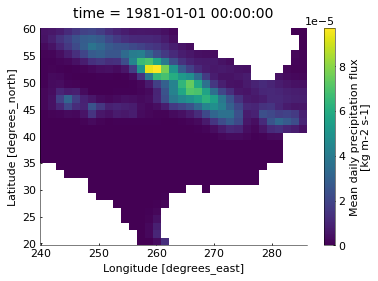

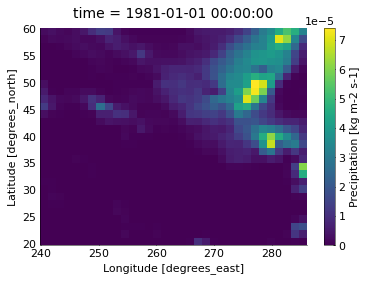

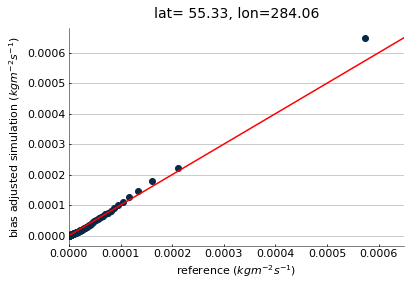

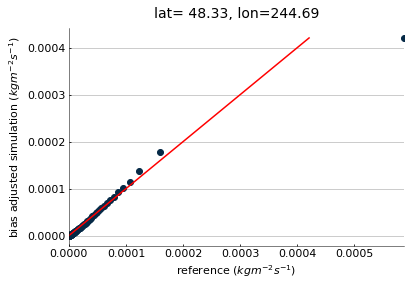

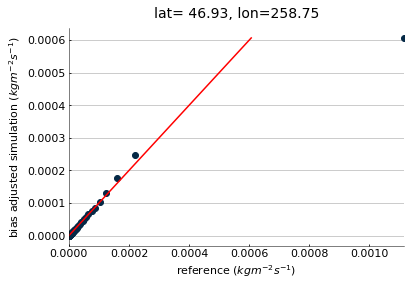

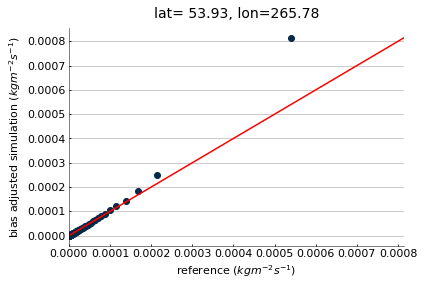

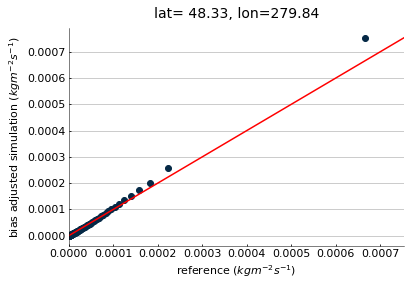

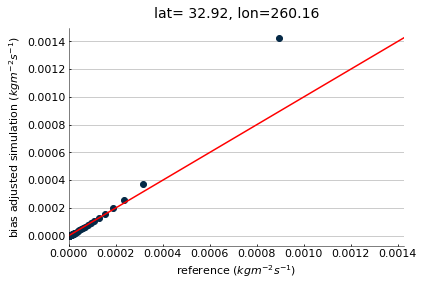

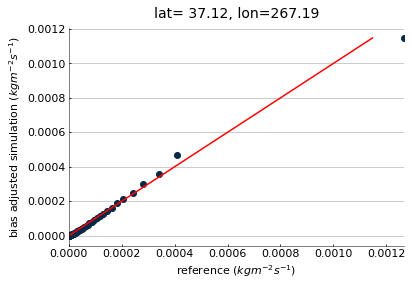

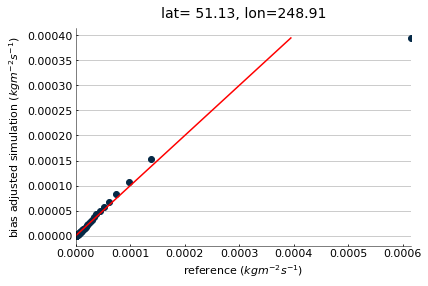

In [170]:
pcat_ref=xs.ProjectCatalog(CONFIG['paths']['cat_ref'])
pcat_sim=xs.ProjectCatalog(CONFIG['paths']['cat_sim'])

import statsmodels
import xesmf
import random
period=['1981','2010']
ds_fin= pcat.search(id='CMIP6_ScenarioMIP_MIROC_MIROC6_ssp370_r1i1p1f1_global', processing_level='final',
                   variable='pr', domain='NAM-rdrs').to_dataset().sel(time=slice(period[0], period[1]))
display(ds_fin)

ds_ref = pcat_ref.search(source='RDRS', variable='pr', xrfreq='D').to_dataset().sel(time=slice(period[0], period[1]))
display(ds_ref)

ds_raw= pcat_sim.search(
    id='CMIP6_ScenarioMIP_MIROC_MIROC6_ssp370_r1i1p1f1_global', processing_level='raw',
    variable='pr').to_dataset().sel(lat=slice(20,60), lon=slice(360-120,360-74)).sel(time=slice(period[0], period[1]))
display(ds_raw)



ds_fin_reg = xs.regrid_dataset(
    ds=ds_fin,
    weights_location=f"{CONFIG['paths']['exec_workdir']}/tmp/gs-weights",
    ds_grid=ds_raw,
    regridder_kwargs={"method":'conservative'},
)
display(ds_fin_reg)

ds_ref_reg = xs.regrid_dataset(
    ds=ds_ref,
    weights_location=f"{CONFIG['paths']['exec_workdir']}/tmp/gs-weights",
    ds_grid=ds_raw,
    regridder_kwargs={"method":'conservative'},
)
ds_ref_reg= xc.core.calendar.convert_calendar(ds_ref_reg, 'noleap')

display(ds_fin_reg)


plt.figure()
ds_fin_reg.pr.isel(time=0).plot()

plt.figure()
ds_ref_reg.pr.isel(time=0).plot()

# https://stats.stackexchange.com/questions/403652/two-sample-quantile-quantile-plot-in-python    
quantiles = np.linspace(start=0, stop=1, num=100)
for i in range(10):
    ilat=random.randint(0,28)
    ilon=random.randint(0,33)
    print(ilat, ilon)
    x=ds_ref_reg.pr.isel(lat=ilat, lon=ilon)
    y=ds_fin_reg.pr.isel(lat=ilat, lon=ilon)
    if ~np.isnan(y.values).any():
        plt.figure()
        x_quantiles = np.quantile(x.values, quantiles, )
        y_quantiles = np.quantile(y.values, quantiles, )
        plt.scatter(x_quantiles, y_quantiles)
        plt.plot([0,y_quantiles[-1]],[0,y_quantiles[-1]], 'r-')
        plt.title(f"lat= {x.lat.values:.2f}, lon={x.lon.values:.2f}")
        plt.xlabel('reference ($kg m^{-2} s^{-1}$)')
        plt.ylabel('bias adjusted simulation ($kg m^{-2} s^{-1}$)')